In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# project root = two levels up from this notebook
RAW_DIR = Path.cwd().parents[1] / "data" / "00_raw"
PROC_DIR = Path.cwd().parents[1] / "data" / "01_processed" / "elset_history_aodr"
FINAL_DIR = Path.cwd().parents[1] / "data" / "02_final"
print(PROC_DIR)  # sanity check
print(FINAL_DIR)  # sanity check

c:\Users\data\01_processed\elset_history_aodr
c:\Users\data\02_final


## Elset Column Explanations
📌 **Identification & Metadata**
* satNo → NORAD satellite catalog number (unique ID across datasets).
* idOnOrbit / idElset → Internal UDL identifiers for that specific elset record.
* epoch → Time the orbit is valid from (reference timestamp).
* epoch_date → (Categorical form of above, likely for partitioning).
* createdAt / createdBy → When/whom the record was ingested into UDL.
* classificationMarking → Security label (probably “UNCLASSIFIED” for your dataset).
* origNetwork / source → Where the record came from (likely “18 SDS” here).

📌 **Orbital Geometry**
These describe the shape and orientation of the orbit:
* semiMajorAxis → Half the longest axis of the orbit ellipse (size of orbit).
* eccentricity → “Roundness” of the orbit (0 = circle, >0 = ellipse).
* inclination → Tilt of the orbit relative to Earth’s equator (0° = equatorial, 90° = polar).
* raan (Right Ascension of Ascending Node) → Where the orbit crosses the equator.
* argOfPerigee → Orientation of the closest point in the orbit.
* meanAnomaly → Position of the satellite in its orbit at the epoch.

📌 **Orbital Motion**
These describe how fast the object moves:
* meanMotion → Revolutions per day (e.g., ~15 rev/day for LEO).
* period → Orbital period in minutes (1 / meanMotion).
* revNo → Revolution number since launch.

📌 **Derived Orbit Properties**
* apogee → Highest altitude above Earth.
* perigee → Lowest altitude above Earth.

📌 **Drag / Perturbation Terms**
These describe how much Earth’s atmosphere & forces perturb the orbit:
* bStar → Atmospheric drag parameter.
* meanMotionDot → First derivative (rate of change of mean motion).
* meanMotionDDot → Second derivative (acceleration of mean motion).
* algorithm → Which orbit determination algorithm was used (often “SGP4”).

## Satellite Catalog Explanations

📌 **Identification & Metadata**
* intldes → International Designator (COSPAR/NSSDC ID). Unique identifier for the object.
* norad_cat_id / object_number → NORAD Catalog Number. Sequential ID assigned by US Space Force.
* object_id → CCSDS identifier corresponding to the International Designator (INTLDES).
* object_name / satname → Common name associated with the object.
* object_type → Classification (e.g., Payload, Rocket Body, Debris).
* country → Nation or group responsible for the object.
* current → Indicates if the object is currently in orbit.
* comment / commentcode → Free-text notes and encoded indicators for the object.
* file → Source file identifier for the data (higher = more recent).

📌 **Launch Information**
* launch → Date the object was launched (`YYYY-MM-DD`).
* site → Launch site code where the object was deployed.
* launch_year → Calendar year of the launch.
* launch_num → Sequential identifier of the launch within that year.
* launch_piece → Piece code (three-letter identifier for objects from the same launch).

📌 **Orbital Motion**
* period → Orbital period in minutes (time to complete one revolution).
* inclination → Tilt of the orbit relative to Earth’s equator, in degrees.

📌 **Derived Orbit Properties**
* apogee → Maximum orbital altitude above Earth (km).
* perigee → Minimum orbital altitude above Earth (km).

📌 **Lifecycle**
* decay → Date the object reentered Earth’s atmosphere (`YYYY-MM-DD`).

📌 **Radar Characteristics**
* rcsvalue → Radar Cross Section value (m²). Indicates detectability by radar.
* rcs_size → Size category inferred from radar cross section.


# Basic Information 

1. Shape and size of the dataset
2. Unique satelites
3. Data types and column names
4. Missing data

### Elset Data

In [3]:
day = "2025-01-01"
day_dir = PROC_DIR / f"epoch_date={day}"

# read the whole partition (all files in that directory)
df_day = pd.read_parquet(day_dir)
df_day.head()

,algorithm,apogee,argOfPerigee,bStar,classificationMarking,createdAt,createdBy,eccentricity,source,semiMajorAxis,...,perigee,origNetwork,meanMotionDot,meanMotionDDot,meanMotion,meanAnomaly,inclination,idOnOrbit,idElset,epoch
0,SGP4,10202.213,259.3559,0.000943,U,2025-01-02 00:05:10.959000+00:00,system.ob-ingest,0.184317,18th SPCS,8614.424,...,7026.636,OPS1,0.000008,0.0,10.858339,79.5230,34.2561,5,<NA>,2025-01-01 01:49:54.598368+00:00
1,SGP4,10202.217,262.2564,0.000996,U,2025-01-02 06:05:08.465000+00:00,system.ob-ingest,0.184319,18th SPCS,8614.417,...,7026.617,OPS1,0.000008,0.0,10.858352,76.5981,34.2564,5,<NA>,2025-01-01 17:17:08.960640+00:00
2,SGP4,9286.717,275.2650,0.001633,U,2025-01-01 23:05:08.691000+00:00,system.ob-ingest,0.145307,18th SPCS,8108.493,...,6930.269,OPS1,0.000031,0.0,11.890292,68.4325,32.8795,11,<NA>,2025-01-01 19:06:31.800960+00:00
3,SGP4,9673.868,173.3927,0.000874,U,2025-01-01 23:05:08.697000+00:00,system.ob-ingest,0.165118,18th SPCS,8302.909,...,6931.950,OPS1,0.000015,0.0,11.475123,189.1611,32.9011,12,<NA>,2025-01-01 19:47:07.123200+00:00
4,SGP4,10594.496,34.2347,0.000585,U,2025-01-02 00:05:10.967000+00:00,system.ob-ingest,0.202279,18th SPCS,8812.011,...,7029.527,OPS1,0.000004,0.0,10.495187,337.3462,34.2656,16,<NA>,2025-01-01 06:18:04.587840+00:00


In [4]:
# Load multiple days
days = ["2025-01-01", "2025-01-02"]
paths = [PROC_DIR / f"epoch_date={d}" for d in days]
df = pd.concat([pd.read_parquet(p) for p in paths], ignore_index=True)
df.head()

,algorithm,apogee,argOfPerigee,bStar,classificationMarking,createdAt,createdBy,eccentricity,source,semiMajorAxis,...,perigee,origNetwork,meanMotionDot,meanMotionDDot,meanMotion,meanAnomaly,inclination,idOnOrbit,idElset,epoch
0,SGP4,10202.213,259.3559,0.000943,U,2025-01-02 00:05:10.959000+00:00,system.ob-ingest,0.184317,18th SPCS,8614.424,...,7026.636,OPS1,0.000008,0.0,10.858339,79.5230,34.2561,5,<NA>,2025-01-01 01:49:54.598368+00:00
1,SGP4,10202.217,262.2564,0.000996,U,2025-01-02 06:05:08.465000+00:00,system.ob-ingest,0.184319,18th SPCS,8614.417,...,7026.617,OPS1,0.000008,0.0,10.858352,76.5981,34.2564,5,<NA>,2025-01-01 17:17:08.960640+00:00
2,SGP4,9286.717,275.2650,0.001633,U,2025-01-01 23:05:08.691000+00:00,system.ob-ingest,0.145307,18th SPCS,8108.493,...,6930.269,OPS1,0.000031,0.0,11.890292,68.4325,32.8795,11,<NA>,2025-01-01 19:06:31.800960+00:00
3,SGP4,9673.868,173.3927,0.000874,U,2025-01-01 23:05:08.697000+00:00,system.ob-ingest,0.165118,18th SPCS,8302.909,...,6931.950,OPS1,0.000015,0.0,11.475123,189.1611,32.9011,12,<NA>,2025-01-01 19:47:07.123200+00:00
4,SGP4,10594.496,34.2347,0.000585,U,2025-01-02 00:05:10.967000+00:00,system.ob-ingest,0.202279,18th SPCS,8812.011,...,7029.527,OPS1,0.000004,0.0,10.495187,337.3462,34.2656,16,<NA>,2025-01-01 06:18:04.587840+00:00


In [5]:
pd.display_max_columns = None  # show all columns

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61979 entries, 0 to 61978
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   algorithm              61979 non-null  object             
 1   apogee                 61979 non-null  float64            
 2   argOfPerigee           61979 non-null  float64            
 3   bStar                  61979 non-null  float64            
 4   classificationMarking  61979 non-null  string             
 5   createdAt              61979 non-null  datetime64[us, UTC]
 6   createdBy              61979 non-null  string             
 7   eccentricity           61979 non-null  float64            
 8   source                 61979 non-null  string             
 9   semiMajorAxis          61979 non-null  float64            
 10  satNo                  61979 non-null  Int64              
 11  revNo                  61979 non-null  Int64          

In [7]:
df_all = pd.read_parquet(PROC_DIR)

df_all.head()

,algorithm,apogee,argOfPerigee,bStar,classificationMarking,createdAt,createdBy,eccentricity,source,semiMajorAxis,...,origNetwork,meanMotionDot,meanMotionDDot,meanMotion,meanAnomaly,inclination,idOnOrbit,idElset,epoch,epoch_date
0,SGP4,10202.213,259.3559,0.000943,U,2025-01-02 00:05:10.959000+00:00,system.ob-ingest,0.184317,18th SPCS,8614.424,...,OPS1,0.000008,0.0,10.858339,79.5230,34.2561,5,<NA>,2025-01-01 01:49:54.598368+00:00,2025-01-01
1,SGP4,10202.217,262.2564,0.000996,U,2025-01-02 06:05:08.465000+00:00,system.ob-ingest,0.184319,18th SPCS,8614.417,...,OPS1,0.000008,0.0,10.858352,76.5981,34.2564,5,<NA>,2025-01-01 17:17:08.960640+00:00,2025-01-01
2,SGP4,9286.717,275.2650,0.001633,U,2025-01-01 23:05:08.691000+00:00,system.ob-ingest,0.145307,18th SPCS,8108.493,...,OPS1,0.000031,0.0,11.890292,68.4325,32.8795,11,<NA>,2025-01-01 19:06:31.800960+00:00,2025-01-01
3,SGP4,9673.868,173.3927,0.000874,U,2025-01-01 23:05:08.697000+00:00,system.ob-ingest,0.165118,18th SPCS,8302.909,...,OPS1,0.000015,0.0,11.475123,189.1611,32.9011,12,<NA>,2025-01-01 19:47:07.123200+00:00,2025-01-01
4,SGP4,10594.496,34.2347,0.000585,U,2025-01-02 00:05:10.967000+00:00,system.ob-ingest,0.202279,18th SPCS,8812.011,...,OPS1,0.000004,0.0,10.495187,337.3462,34.2656,16,<NA>,2025-01-01 06:18:04.587840+00:00,2025-01-01


In [8]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578380 entries, 0 to 9578379
Data columns (total 25 columns):
 #   Column                 Dtype              
---  ------                 -----              
 0   algorithm              object             
 1   apogee                 float64            
 2   argOfPerigee           float64            
 3   bStar                  float64            
 4   classificationMarking  string             
 5   createdAt              datetime64[us, UTC]
 6   createdBy              string             
 7   eccentricity           float64            
 8   source                 string             
 9   semiMajorAxis          float64            
 10  satNo                  Int64              
 11  revNo                  Int64              
 12  raan                   float64            
 13  period                 float64            
 14  perigee                float64            
 15  origNetwork            object             
 16  meanMotionDot     

In [9]:
pd.set_option('display.max_columns', None) 

In [10]:
df_all.head()

,algorithm,apogee,argOfPerigee,bStar,classificationMarking,createdAt,createdBy,eccentricity,source,semiMajorAxis,satNo,revNo,raan,period,perigee,origNetwork,meanMotionDot,meanMotionDDot,meanMotion,meanAnomaly,inclination,idOnOrbit,idElset,epoch,epoch_date
0,SGP4,10202.213,259.3559,0.000943,U,2025-01-02 00:05:10.959000+00:00,system.ob-ingest,0.184317,18th SPCS,8614.424,5,38543,156.6751,132.617,7026.636,OPS1,0.000008,0.0,10.858339,79.5230,34.2561,5,<NA>,2025-01-01 01:49:54.598368+00:00,2025-01-01
1,SGP4,10202.217,262.2564,0.000996,U,2025-01-02 06:05:08.465000+00:00,system.ob-ingest,0.184319,18th SPCS,8614.417,5,38550,154.6883,132.617,7026.617,OPS1,0.000008,0.0,10.858352,76.5981,34.2564,5,<NA>,2025-01-01 17:17:08.960640+00:00,2025-01-01
2,SGP4,9286.717,275.2650,0.001633,U,2025-01-01 23:05:08.691000+00:00,system.ob-ingest,0.145307,18th SPCS,8108.493,11,81389,294.6285,121.107,6930.269,OPS1,0.000031,0.0,11.890292,68.4325,32.8795,11,<NA>,2025-01-01 19:06:31.800960+00:00,2025-01-01
3,SGP4,9673.868,173.3927,0.000874,U,2025-01-01 23:05:08.697000+00:00,system.ob-ingest,0.165118,18th SPCS,8302.909,12,71282,296.3941,125.489,6931.950,OPS1,0.000015,0.0,11.475123,189.1611,32.9011,12,<NA>,2025-01-01 19:47:07.123200+00:00,2025-01-01
4,SGP4,10594.496,34.2347,0.000585,U,2025-01-02 00:05:10.967000+00:00,system.ob-ingest,0.202279,18th SPCS,8812.011,16,63302,43.3806,137.206,7029.527,OPS1,0.000004,0.0,10.495187,337.3462,34.2656,16,<NA>,2025-01-01 06:18:04.587840+00:00,2025-01-01


In [11]:
df_all.satNo.nunique()

29715

There are 29,715 unique objects in this dataset. 

In [12]:
df_all.columns

Index(['algorithm', 'apogee', 'argOfPerigee', 'bStar', 'classificationMarking',
       'createdAt', 'createdBy', 'eccentricity', 'source', 'semiMajorAxis',
       'satNo', 'revNo', 'raan', 'period', 'perigee', 'origNetwork',
       'meanMotionDot', 'meanMotionDDot', 'meanMotion', 'meanAnomaly',
       'inclination', 'idOnOrbit', 'idElset', 'epoch', 'epoch_date'],
      dtype='object')

In [13]:
df_all.isna().sum().reset_index().rename(columns={0: 'n_missing'}).sort_values(by='n_missing', ascending=False)

,index,n_missing
22,idElset,9578380
0,algorithm,292630
13,period,292617
16,meanMotionDot,289237
17,meanMotionDDot,289237
3,bStar,208418
1,apogee,126999
11,revNo,126999
14,perigee,126999
9,semiMajorAxis,126999


In [14]:
len(df_all)

9578380

In [15]:
df_all.describe()

,apogee,argOfPerigee,bStar,eccentricity,semiMajorAxis,satNo,revNo,raan,period,perigee,meanMotionDot,meanMotionDDot,meanMotion,meanAnomaly,inclination,idOnOrbit,idElset
count,9.451381e+06,9.578380e+06,9.369962e+06,9.578380e+06,9.451381e+06,9553578.0,9451381.0,9.578380e+06,9.285763e+06,9.451381e+06,9.289143e+06,9.289143e+06,9.578380e+06,9.578380e+06,9.578380e+06,9510016.0,0.0
mean,1.109690e+04,1.709633e+02,6.468430e-04,3.024010e-02,1.048484e+04,42400.170961,26247.793648,1.780623e+02,2.028265e+02,9.872779e+03,7.817271e-05,5.996552e-06,1.294574e+01,1.897551e+02,6.667234e+01,41804.824649,<NA>
std,1.127883e+04,9.952165e+01,1.174821e-02,1.225286e-01,9.858333e+03,21044.067887,27795.881449,1.051278e+02,3.492763e+02,9.346872e+03,2.914913e-03,8.259428e-04,4.332653e+00,1.013773e+02,2.924943e+01,18105.358685,<NA>
min,6.495761e+03,1.000000e-04,-2.325100e+00,2.000000e-07,6.494273e+03,5.0,0.0,1.000000e-04,8.680700e+01,4.901396e+03,-5.238787e-01,-5.555500e-05,2.779772e-02,1.000000e-04,1.000000e-04,5.0,<NA>
25%,6.918725e+03,8.707820e+01,2.042600e-05,1.581000e-04,6.917828e+03,27870.0,6194.0,8.532500e+01,9.537800e+01,6.876489e+03,1.900000e-07,0.000000e+00,1.347193e+01,9.300570e+01,4.997220e+01,27819.0,<NA>
50%,7.081625e+03,1.558434e+02,1.881800e-04,8.113000e-04,7.053628e+03,47355.0,14580.0,1.744314e+02,9.786100e+01,6.961722e+03,7.580000e-06,0.000000e+00,1.464631e+01,2.073347e+02,7.000020e+01,47261.0,<NA>
75%,7.561168e+03,2.667121e+02,7.537500e-04,4.997800e-03,7.446971e+03,57474.0,36095.0,2.711343e+02,1.054320e+02,7.274220e+03,5.669000e-05,0.000000e+00,1.508854e+01,2.736609e+02,9.742150e+01,57386.0,<NA>
max,6.195078e+05,3.599999e+02,8.779300e+00,9.653600e-01,4.603227e+05,270446.0,99999.0,3.600000e+02,5.180281e+04,3.072422e+05,1.000000e+00,4.809900e-01,1.658850e+01,3.599999e+02,1.537180e+02,65077.0,<NA>


### Satellite Catelog

In [16]:
satcat = pd.read_csv(RAW_DIR / "satcat.csv")
satcat.head()

,INTLDES,NORAD_CAT_ID,OBJECT_TYPE,SATNAME,COUNTRY,LAUNCH,SITE,DECAY,PERIOD,INCLINATION,APOGEE,PERIGEE,COMMENT,COMMENTCODE,RCSVALUE,RCS_SIZE,FILE,LAUNCH_YEAR,LAUNCH_NUM,LAUNCH_PIECE,CURRENT,OBJECT_NAME,OBJECT_ID,OBJECT_NUMBER
0,1957-001A,1,ROCKET BODY,SL-1 R/B,CIS,1957-10-04,TTMTR,1957-12-01,96.19,65.10,938.0,214.0,NaN,4.0,0,LARGE,1,1957,1,A,Y,SL-1 R/B,1957-001A,1
1,1957-001B,2,PAYLOAD,SPUTNIK 1,CIS,1957-10-04,TTMTR,1958-01-03,96.10,65.00,1080.0,64.0,NaN,NaN,0,NaN,7179,1957,1,B,Y,SPUTNIK 1,1957-001B,2
2,1957-002A,3,PAYLOAD,SPUTNIK 2,CIS,1957-11-03,TTMTR,1958-04-14,103.74,65.33,1659.0,211.0,NaN,NaN,0,SMALL,9221,1957,2,A,Y,SPUTNIK 2,1957-002A,3
3,1958-001A,4,PAYLOAD,EXPLORER 1,US,1958-02-01,AFETR,1970-03-31,88.48,33.15,215.0,183.0,NaN,NaN,0,NaN,1,1958,1,A,Y,EXPLORER 1,1958-001A,4
4,1958-002B,5,PAYLOAD,VANGUARD 1,US,1958-03-17,AFETR,NaN,132.61,34.26,3823.0,649.0,NaN,NaN,0,SMALL,9235,1958,2,B,Y,VANGUARD 1,1958-002B,5


# debris_payload CSV export

In [17]:
debris_payload = satcat.drop(columns=['SITE', 'COMMENT', 'COMMENTCODE', 'RCSVALUE'])
debris_payload.to_csv("debris_payload.csv", index=False)

In [18]:
satcat.columns

Index(['INTLDES', 'NORAD_CAT_ID', 'OBJECT_TYPE', 'SATNAME', 'COUNTRY',
       'LAUNCH', 'SITE', 'DECAY', 'PERIOD', 'INCLINATION', 'APOGEE', 'PERIGEE',
       'COMMENT', 'COMMENTCODE', 'RCSVALUE', 'RCS_SIZE', 'FILE', 'LAUNCH_YEAR',
       'LAUNCH_NUM', 'LAUNCH_PIECE', 'CURRENT', 'OBJECT_NAME', 'OBJECT_ID',
       'OBJECT_NUMBER'],
      dtype='object')

In [19]:
satcat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65265 entries, 0 to 65264
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   INTLDES        65265 non-null  object 
 1   NORAD_CAT_ID   65265 non-null  int64  
 2   OBJECT_TYPE    65265 non-null  object 
 3   SATNAME        65265 non-null  object 
 4   COUNTRY        65265 non-null  object 
 5   LAUNCH         65265 non-null  object 
 6   SITE           65265 non-null  object 
 7   DECAY          33988 non-null  object 
 8   PERIOD         64273 non-null  float64
 9   INCLINATION    64273 non-null  float64
 10  APOGEE         64273 non-null  float64
 11  PERIGEE        64273 non-null  float64
 12  COMMENT        965 non-null    object 
 13  COMMENTCODE    3670 non-null   float64
 14  RCSVALUE       65265 non-null  int64  
 15  RCS_SIZE       54449 non-null  object 
 16  FILE           65265 non-null  int64  
 17  LAUNCH_YEAR    65265 non-null  int64  
 18  LAUNCH

In [20]:
satcat.columns = satcat.columns.str.strip().str.lower()
satcat.columns

Index(['intldes', 'norad_cat_id', 'object_type', 'satname', 'country',
       'launch', 'site', 'decay', 'period', 'inclination', 'apogee', 'perigee',
       'comment', 'commentcode', 'rcsvalue', 'rcs_size', 'file', 'launch_year',
       'launch_num', 'launch_piece', 'current', 'object_name', 'object_id',
       'object_number'],
      dtype='object')

In [21]:
satcat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65265 entries, 0 to 65264
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   intldes        65265 non-null  object 
 1   norad_cat_id   65265 non-null  int64  
 2   object_type    65265 non-null  object 
 3   satname        65265 non-null  object 
 4   country        65265 non-null  object 
 5   launch         65265 non-null  object 
 6   site           65265 non-null  object 
 7   decay          33988 non-null  object 
 8   period         64273 non-null  float64
 9   inclination    64273 non-null  float64
 10  apogee         64273 non-null  float64
 11  perigee        64273 non-null  float64
 12  comment        965 non-null    object 
 13  commentcode    3670 non-null   float64
 14  rcsvalue       65265 non-null  int64  
 15  rcs_size       54449 non-null  object 
 16  file           65265 non-null  int64  
 17  launch_year    65265 non-null  int64  
 18  launch

In [22]:
satcat['norad_cat_id'].nunique()

65265

In [23]:
satcat.describe()

,norad_cat_id,period,inclination,apogee,perigee,commentcode,rcsvalue,file,launch_year,launch_num,object_number
count,65265.000000,64273.000000,64273.000000,64273.000000,64273.000000,3670.000000,65265.0,65265.00000,65265.000000,65265.000000,65265.000000
mean,32643.223045,177.086338,68.850224,3505.692064,1731.541005,3.388556,0.0,7296.48467,1997.327557,60.602176,32643.223045
std,18854.766362,688.899073,25.017626,13814.289005,6648.313714,1.334279,0.0,3213.70126,19.701192,44.098971,18854.766362
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,1.00000,1957.000000,0.000000,1.000000
25%,16317.000000,89.280000,53.010000,268.000000,197.000000,3.000000,0.0,7337.00000,1982.000000,25.000000,16317.000000
50%,32633.000000,94.110000,70.000000,484.000000,419.000000,3.000000,0.0,9029.00000,1997.000000,52.000000,32633.000000
75%,48949.000000,101.040000,92.240000,872.000000,667.000000,5.000000,0.0,9235.00000,2020.000000,86.000000,48949.000000
max,65322.000000,95687.680000,150.940000,641287.000000,314973.000000,5.000000,0.0,9240.00000,2025.000000,254.000000,65322.000000


In [24]:
satcat['object_type'].value_counts()

object_type
DEBRIS         35726
PAYLOAD        21844
ROCKET BODY     6743
UNKNOWN          952
Name: count, dtype: int64

In [25]:
satcat['country'].value_counts()

country
CIS    25033
US     24961
PRC     8658
FR      1471
JPN      873
       ...  
UGA        1
MCO        1
HRV        1
BWA        1
BHR        1
Name: count, Length: 121, dtype: int64

In [26]:
satcat['country'].nunique()

121

## Cleaning and Data Wrangling

1. Merge satellite catelog to elset data
2. Keep the latest epoch of data for each satellite in the elset data
3. Remove unnecesary columns
Assign orbit class to each object:
    - LEO (<2,000 km perigee)
    - MEO (2,000–35,000 km)
    - GEO (near 35,786 km ± 200 km)
    - HEO (eccentric >0.1, apogee > GEO)

In [27]:
# intial check of matching satellite numbers between datasets
sat_list = satcat[['norad_cat_id']].drop_duplicates().rename(columns={'norad_cat_id': 'satNo'})
sat_no_list = df_all[['satNo']].drop_duplicates()
merged = sat_no_list[['satNo']].merge(sat_list, on='satNo', how='outer', indicator=True)
merged['_merge'].value_counts()

_merge
right_only    36125
both          29140
left_only       576
Name: count, dtype: int64

Only keep rows in both datasets

In [28]:
df_all.head()

,algorithm,apogee,argOfPerigee,bStar,classificationMarking,createdAt,createdBy,eccentricity,source,semiMajorAxis,satNo,revNo,raan,period,perigee,origNetwork,meanMotionDot,meanMotionDDot,meanMotion,meanAnomaly,inclination,idOnOrbit,idElset,epoch,epoch_date
0,SGP4,10202.213,259.3559,0.000943,U,2025-01-02 00:05:10.959000+00:00,system.ob-ingest,0.184317,18th SPCS,8614.424,5,38543,156.6751,132.617,7026.636,OPS1,0.000008,0.0,10.858339,79.5230,34.2561,5,<NA>,2025-01-01 01:49:54.598368+00:00,2025-01-01
1,SGP4,10202.217,262.2564,0.000996,U,2025-01-02 06:05:08.465000+00:00,system.ob-ingest,0.184319,18th SPCS,8614.417,5,38550,154.6883,132.617,7026.617,OPS1,0.000008,0.0,10.858352,76.5981,34.2564,5,<NA>,2025-01-01 17:17:08.960640+00:00,2025-01-01
2,SGP4,9286.717,275.2650,0.001633,U,2025-01-01 23:05:08.691000+00:00,system.ob-ingest,0.145307,18th SPCS,8108.493,11,81389,294.6285,121.107,6930.269,OPS1,0.000031,0.0,11.890292,68.4325,32.8795,11,<NA>,2025-01-01 19:06:31.800960+00:00,2025-01-01
3,SGP4,9673.868,173.3927,0.000874,U,2025-01-01 23:05:08.697000+00:00,system.ob-ingest,0.165118,18th SPCS,8302.909,12,71282,296.3941,125.489,6931.950,OPS1,0.000015,0.0,11.475123,189.1611,32.9011,12,<NA>,2025-01-01 19:47:07.123200+00:00,2025-01-01
4,SGP4,10594.496,34.2347,0.000585,U,2025-01-02 00:05:10.967000+00:00,system.ob-ingest,0.202279,18th SPCS,8812.011,16,63302,43.3806,137.206,7029.527,OPS1,0.000004,0.0,10.495187,337.3462,34.2656,16,<NA>,2025-01-01 06:18:04.587840+00:00,2025-01-01


In [29]:
satcat.head()

,intldes,norad_cat_id,object_type,satname,country,launch,site,decay,period,inclination,apogee,perigee,comment,commentcode,rcsvalue,rcs_size,file,launch_year,launch_num,launch_piece,current,object_name,object_id,object_number
0,1957-001A,1,ROCKET BODY,SL-1 R/B,CIS,1957-10-04,TTMTR,1957-12-01,96.19,65.10,938.0,214.0,NaN,4.0,0,LARGE,1,1957,1,A,Y,SL-1 R/B,1957-001A,1
1,1957-001B,2,PAYLOAD,SPUTNIK 1,CIS,1957-10-04,TTMTR,1958-01-03,96.10,65.00,1080.0,64.0,NaN,NaN,0,NaN,7179,1957,1,B,Y,SPUTNIK 1,1957-001B,2
2,1957-002A,3,PAYLOAD,SPUTNIK 2,CIS,1957-11-03,TTMTR,1958-04-14,103.74,65.33,1659.0,211.0,NaN,NaN,0,SMALL,9221,1957,2,A,Y,SPUTNIK 2,1957-002A,3
3,1958-001A,4,PAYLOAD,EXPLORER 1,US,1958-02-01,AFETR,1970-03-31,88.48,33.15,215.0,183.0,NaN,NaN,0,NaN,1,1958,1,A,Y,EXPLORER 1,1958-001A,4
4,1958-002B,5,PAYLOAD,VANGUARD 1,US,1958-03-17,AFETR,NaN,132.61,34.26,3823.0,649.0,NaN,NaN,0,SMALL,9235,1958,2,B,Y,VANGUARD 1,1958-002B,5


In [30]:
merged = df_all.merge(satcat, left_on='satNo', right_on='norad_cat_id', how='inner', suffixes=('_els', '_sat'))
merged.shape

(9510016, 49)

In [31]:
# check differences in orbital parameters between datasets
stats_check = merged[['apogee_els', 'apogee_sat', 'perigee_els', 'perigee_sat', 'period_els', 'period_sat']].copy()
stats_check['apogee_diff'] = stats_check['apogee_els'] - stats_check['apogee_sat']
stats_check['perigee_diff'] = stats_check['perigee_els'] - stats_check['perigee_sat']
stats_check['period_diff'] = stats_check['period_els'] - stats_check['period_sat']
stats_check.head(10)

,apogee_els,apogee_sat,perigee_els,perigee_sat,period_els,period_sat,apogee_diff,perigee_diff,period_diff
0,10202.213,3823.0,7026.636,649.0,132.617,132.61,6379.213,6377.636,0.007
1,10202.217,3823.0,7026.617,649.0,132.617,132.61,6379.217,6377.617,0.007
2,9286.717,2900.0,6930.269,552.0,121.107,121.01,6386.717,6378.269,0.097
3,9673.868,3290.0,6931.950,556.0,125.489,125.45,6383.868,6375.950,0.039
4,10594.496,4217.0,7029.527,650.0,137.206,137.20,6377.496,6379.527,0.006
5,9597.348,3213.0,6886.204,509.0,124.105,124.04,6384.348,6377.204,0.065
6,9597.322,3213.0,6886.212,509.0,124.105,124.04,6384.322,6377.212,0.065
7,6972.199,565.0,6832.162,443.0,95.113,94.70,6407.199,6389.162,0.413
8,6972.024,565.0,6832.128,443.0,95.111,94.70,6407.024,6389.128,0.411
9,7031.000,651.0,7000.123,620.0,97.466,97.42,6380.000,6380.123,0.046


In [32]:
stats_check.describe()

,apogee_els,apogee_sat,perigee_els,perigee_sat,period_els,period_sat,apogee_diff,perigee_diff,period_diff
count,9.400128e+06,9.509384e+06,9.400128e+06,9.509384e+06,9.242801e+06,9.509384e+06,9.399509e+06,9.399509e+06,9.242182e+06
mean,1.107926e+04,4.738493e+03,9.857155e+03,3.516206e+03,2.031563e+02,2.247050e+02,6.395982e+03,6.382509e+03,2.615757e-01
std,1.126123e+04,1.132044e+04,9.324520e+03,9.394080e+03,3.499089e+02,3.841806e+02,4.388793e+02,2.815223e+02,2.717809e+01
min,6.495761e+03,9.500000e+01,4.901396e+03,0.000000e+00,8.680700e+01,8.630000e+01,-2.442230e+05,-1.738973e+05,-2.896944e+04
25%,6.918712e+03,5.380000e+02,6.875817e+03,4.900000e+02,9.534900e+01,9.510000e+01,6.377797e+03,6.377737e+03,-2.000000e-03
50%,7.078346e+03,6.960000e+02,6.959703e+03,5.770000e+02,9.780200e+01,9.805000e+01,6.378457e+03,6.378480e+03,4.000000e-03
75%,7.557430e+03,1.183000e+03,7.271018e+03,8.970000e+02,1.053160e+02,1.065900e+02,6.382093e+03,6.381032e+03,5.100000e-02
max,6.195078e+05,6.385230e+05,3.072422e+05,3.149730e+05,5.180281e+04,5.569945e+04,7.279530e+04,1.572103e+05,1.605252e+04


Most differences in apogee and perigee appear to be due to the Earth's radius being included in the elset dataset vs not included in the satellite catelog. I will account for this and create new apogee and perigee columns.

In [33]:
# keep only the latest epoch for each satellite
df_latest = (merged.sort_values("epoch")
                      .groupby("satNo")
                      .tail(1))
df_latest.shape

(29140, 49)

In [34]:
df_latest.head()

,algorithm,apogee_els,argOfPerigee,bStar,classificationMarking,createdAt,createdBy,eccentricity,source,semiMajorAxis,satNo,revNo,raan,period_els,perigee_els,origNetwork,meanMotionDot,meanMotionDDot,meanMotion,meanAnomaly,inclination_els,idOnOrbit,idElset,epoch,epoch_date,intldes,norad_cat_id,object_type,satname,country,launch,site,decay,period_sat,inclination_sat,apogee_sat,perigee_sat,comment,commentcode,rcsvalue,rcs_size,file,launch_year,launch_num,launch_piece,current,object_name,object_id,object_number
31636,SGP4,6713.220,158.0519,0.071972,U,2025-01-01 16:05:13.461000+00:00,system.ob-ingest,0.002807,18th SPCS,6694.428,60773,2104,332.9594,90.851,6675.636,OPS1,0.123356,0.274000,15.850119,202.1971,88.9702,60773,<NA>,2025-01-01 05:40:21.204192+00:00,2025-01-01,2024-140EY,60773,DEBRIS,CZ-6A DEB,PRC,2024-08-06,TSC,2025-01-06,90.85,88.97,335.0,298.0,NaN,NaN,0,SMALL,9003,2024,140,EY,Y,CZ-6A DEB,2024-140EY,60773
25359,SGP4,6572.676,274.5234,0.000266,U,2025-01-02 00:05:13.604000+00:00,system.ob-ingest,0.000283,18th SPCS,6570.814,56091,10246,70.4408,88.346,6568.951,OPS1,0.011464,0.000002,16.299491,131.9252,96.3242,56091,<NA>,2025-01-01 06:26:51.037728+00:00,2025-01-01,2023-045A,56091,PAYLOAD,COSMOS 2568,CIS,2023-03-29,PKMTR,2025-01-03,87.19,96.33,141.0,130.0,NaN,NaN,0,LARGE,9000,2023,45,A,Y,COSMOS 2568,2023-045A,56091
11943,SGP4,6689.589,333.9987,0.015160,U,2025-01-01 15:05:11.434000+00:00,system.ob-ingest,0.002177,18th SPCS,6675.056,33989,84795,57.0027,90.457,6660.522,OPS1,0.041511,0.022317,15.919171,26.0151,73.9751,33989,<NA>,2025-01-01 09:48:54.658944+00:00,2025-01-01,1993-036FY,33989,DEBRIS,COSMOS 2251 DEB,CIS,1993-06-16,PKMTR,2025-01-06,90.46,73.98,311.0,282.0,NaN,NaN,0,SMALL,9003,1993,36,FY,Y,COSMOS 2251 DEB,1993-036FY,33989
22797,SGP4,6525.653,212.6438,0.000296,U,2025-01-01 12:05:11.766000+00:00,system.ob-ingest,0.000228,18th SPCS,6524.163,53714,12937,346.7018,87.407,6522.674,OPS1,0.158177,0.000013,16.474625,285.8411,53.2010,53714,<NA>,2025-01-01 10:32:12.338880+00:00,2025-01-01,2022-107Q,53714,PAYLOAD,STARLINK-4688,US,2022-09-05,AFETR,2025-01-01,87.41,53.20,148.0,145.0,NaN,NaN,0,LARGE,9000,2022,107,Q,Y,STARLINK-4688,2022-107Q,53714
13338,SGP4,7100.459,59.2819,0.018898,U,2025-01-01 23:05:11.521000+00:00,system.ob-ingest,0.001498,18th SPCS,7089.840,38275,74271,262.7376,99.018,7079.222,OPS1,0.000812,0.000000,14.542801,300.9849,81.1576,38275,<NA>,2025-01-01 10:44:23.122176+00:00,2025-01-01,1979-095BV,38275,DEBRIS,METEOR 2-5 DEB,CIS,1979-10-31,PKMTR,NaN,99.02,81.16,722.0,701.0,NaN,1.0,0,SMALL,9029,1979,95,BV,Y,METEOR 2-5 DEB,1979-095BV,38275


In [35]:
# identify missing values in the latest dataset
missing_values = df_latest.isna().sum().reset_index().rename(columns={0: 'n_missing'}).sort_values(by='n_missing', ascending=False)
missing_values = missing_values[missing_values['n_missing'] > 0]
missing_values

,index,n_missing
22,idElset,29140
37,comment,29134
38,commentcode,28865
32,decay,27942
40,rcs_size,412
1,apogee_els,31
14,perigee_els,31
11,revNo,31
0,algorithm,31
13,period_els,31


In [36]:
# remove unnecesary columns
df_sat = df_latest.drop(columns=['idElset','comment', 'commentcode', 'createdBy', 'source', 'origNetwork', 'algorithm', 'classificationMarking', 'current'])
df_sat.head()

,apogee_els,argOfPerigee,bStar,createdAt,eccentricity,semiMajorAxis,satNo,revNo,raan,period_els,perigee_els,meanMotionDot,meanMotionDDot,meanMotion,meanAnomaly,inclination_els,idOnOrbit,epoch,epoch_date,intldes,norad_cat_id,object_type,satname,country,launch,site,decay,period_sat,inclination_sat,apogee_sat,perigee_sat,rcsvalue,rcs_size,file,launch_year,launch_num,launch_piece,object_name,object_id,object_number
31636,6713.220,158.0519,0.071972,2025-01-01 16:05:13.461000+00:00,0.002807,6694.428,60773,2104,332.9594,90.851,6675.636,0.123356,0.274000,15.850119,202.1971,88.9702,60773,2025-01-01 05:40:21.204192+00:00,2025-01-01,2024-140EY,60773,DEBRIS,CZ-6A DEB,PRC,2024-08-06,TSC,2025-01-06,90.85,88.97,335.0,298.0,0,SMALL,9003,2024,140,EY,CZ-6A DEB,2024-140EY,60773
25359,6572.676,274.5234,0.000266,2025-01-02 00:05:13.604000+00:00,0.000283,6570.814,56091,10246,70.4408,88.346,6568.951,0.011464,0.000002,16.299491,131.9252,96.3242,56091,2025-01-01 06:26:51.037728+00:00,2025-01-01,2023-045A,56091,PAYLOAD,COSMOS 2568,CIS,2023-03-29,PKMTR,2025-01-03,87.19,96.33,141.0,130.0,0,LARGE,9000,2023,45,A,COSMOS 2568,2023-045A,56091
11943,6689.589,333.9987,0.015160,2025-01-01 15:05:11.434000+00:00,0.002177,6675.056,33989,84795,57.0027,90.457,6660.522,0.041511,0.022317,15.919171,26.0151,73.9751,33989,2025-01-01 09:48:54.658944+00:00,2025-01-01,1993-036FY,33989,DEBRIS,COSMOS 2251 DEB,CIS,1993-06-16,PKMTR,2025-01-06,90.46,73.98,311.0,282.0,0,SMALL,9003,1993,36,FY,COSMOS 2251 DEB,1993-036FY,33989
22797,6525.653,212.6438,0.000296,2025-01-01 12:05:11.766000+00:00,0.000228,6524.163,53714,12937,346.7018,87.407,6522.674,0.158177,0.000013,16.474625,285.8411,53.2010,53714,2025-01-01 10:32:12.338880+00:00,2025-01-01,2022-107Q,53714,PAYLOAD,STARLINK-4688,US,2022-09-05,AFETR,2025-01-01,87.41,53.20,148.0,145.0,0,LARGE,9000,2022,107,Q,STARLINK-4688,2022-107Q,53714
13338,7100.459,59.2819,0.018898,2025-01-01 23:05:11.521000+00:00,0.001498,7089.840,38275,74271,262.7376,99.018,7079.222,0.000812,0.000000,14.542801,300.9849,81.1576,38275,2025-01-01 10:44:23.122176+00:00,2025-01-01,1979-095BV,38275,DEBRIS,METEOR 2-5 DEB,CIS,1979-10-31,PKMTR,NaN,99.02,81.16,722.0,701.0,0,SMALL,9029,1979,95,BV,METEOR 2-5 DEB,1979-095BV,38275


In [37]:
df_sat['object_type'].unique()

array(['DEBRIS', 'PAYLOAD', 'UNKNOWN', 'ROCKET BODY'], dtype=object)

# Object Counts viz

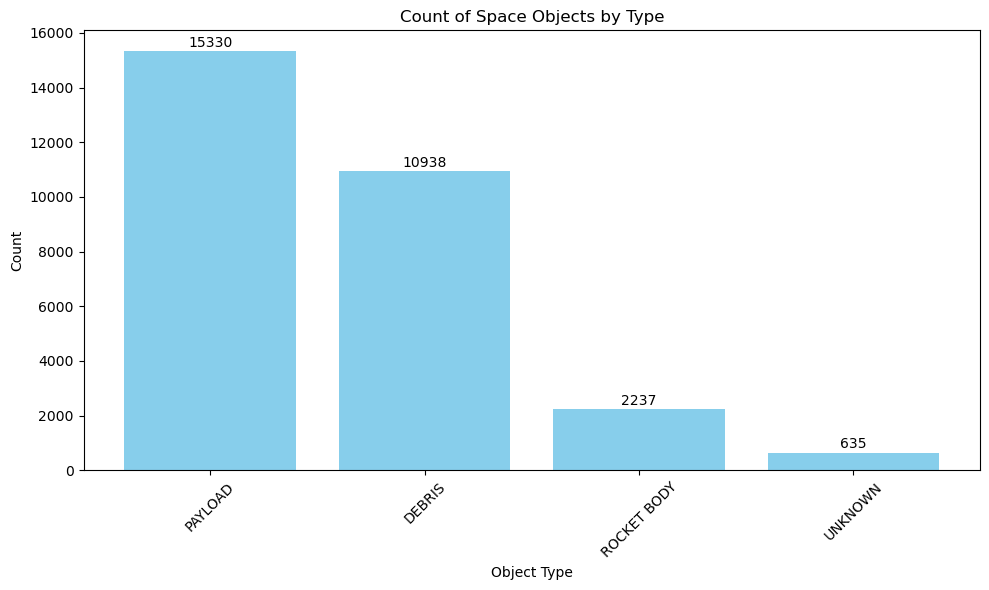

In [38]:
# Get object type counts
object_type_counts = df_sat['object_type'].value_counts()

# Create the plot
plt.figure(figsize=(10, 6))
bars = plt.bar(object_type_counts.index, object_type_counts.values, color='skyblue')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 50,
             f'{int(height)}', ha='center', va='bottom')

plt.title('Count of Space Objects by Type')
plt.xlabel('Object Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create launch year bins

In [39]:
df_sat['launch_year'].value_counts().sort_index()

launch_year
1958       3
1959       5
1960      11
1961     210
1962      25
        ... 
2021    1408
2022    2728
2023    2701
2024    3376
2025    2321
Name: count, Length: 68, dtype: int64

In [40]:
lauch_year_dict = {'1950s': range(1950, 1960),
                   '1960s': range(1960, 1970),
                   '1970s': range(1970, 1980),
                   '1980s': range(1980, 1990),
                   '1990s': range(1990, 2000),
                   '2000s': range(2000, 2010),
                   '2010s': range(2010, 2020),
                   '2020s': range(2020, 2030)}

def classify_launch_year(year):
    if pd.isna(year): return "Unknown"
    for decade, years in lauch_year_dict.items():
        if year in years:
            return decade
    return "Unknown"

df_sat['launch_decade'] = df_sat['launch_year'].apply(classify_launch_year)
df_sat['launch_decade'].value_counts().sort_index()

launch_decade
1950s        8
1960s     1314
1970s     2655
1980s     2397
1990s     5120
2000s     1780
2010s     2500
2020s    13366
Name: count, dtype: int64

In [41]:
df_sat[df_sat['object_type'] == 'Debris']['launch_decade'].value_counts().sort_index()

Series([], Name: count, dtype: int64)

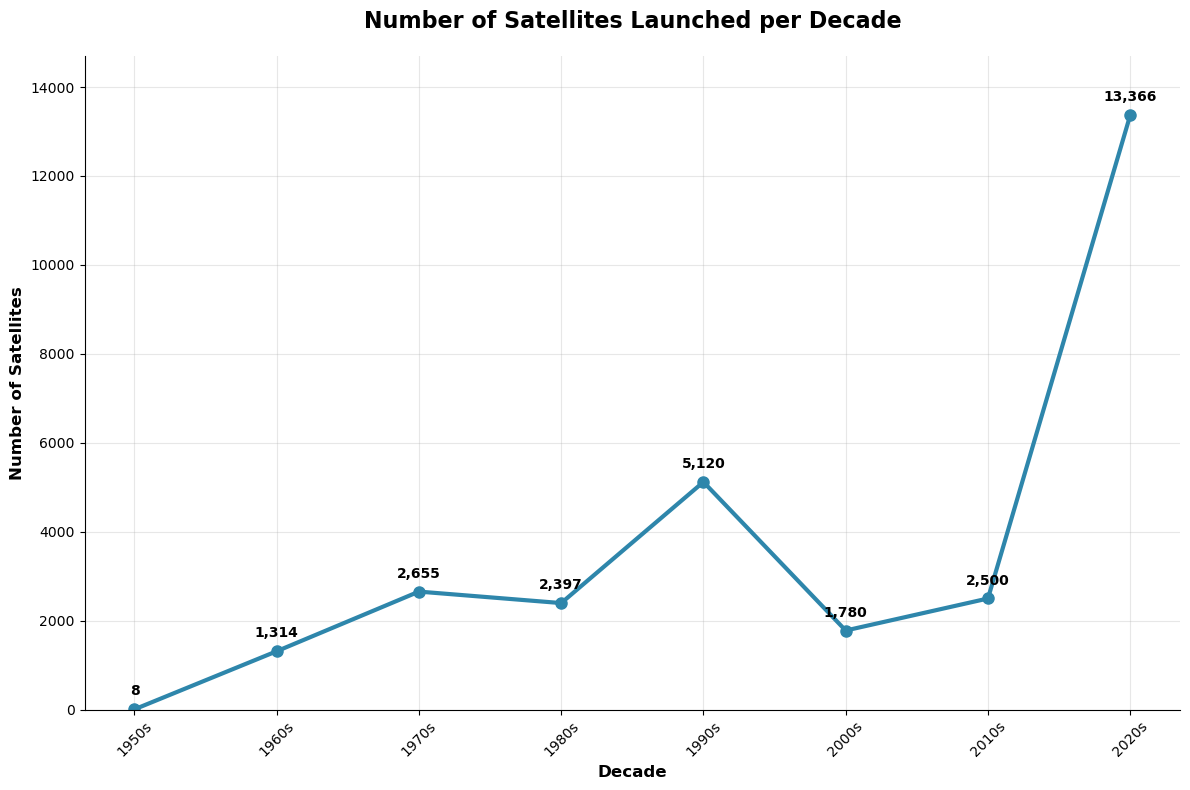

In [42]:
# Create the visualization
plt.figure(figsize=(12, 8))

decades = ['1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s', '2020s']
satellite_counts = [8,  # 1958-1959
                   df_sat['launch_decade'].value_counts().sort_index().get('1960s', 0),
                   df_sat['launch_decade'].value_counts().sort_index().get('1970s', 0),
                   df_sat['launch_decade'].value_counts().sort_index().get('1980s', 0),
                   df_sat['launch_decade'].value_counts().sort_index().get('1990s', 0),
                   df_sat['launch_decade'].value_counts().sort_index().get('2000s', 0),
                   df_sat['launch_decade'].value_counts().sort_index().get('2010s', 0),
                   df_sat['launch_decade'].value_counts().sort_index().get('2020s', 0)]

# Create line plot
line = plt.plot(decades, satellite_counts, marker='o', linewidth=3, markersize=8, color='#2E86AB')

# Add value annotations on each point
for i, count in enumerate(satellite_counts):
    plt.annotate(f'{count:,}', 
                 (decades[i], satellite_counts[i]), 
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center',
                 fontweight='bold')

# Customize the plot
plt.title('Number of Satellites Launched per Decade', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Decade', fontsize=12, fontweight='bold')
plt.ylabel('Number of Satellites', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Set y-axis to start from 0
plt.ylim(0, max(satellite_counts) * 1.1)

# Add some styling
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


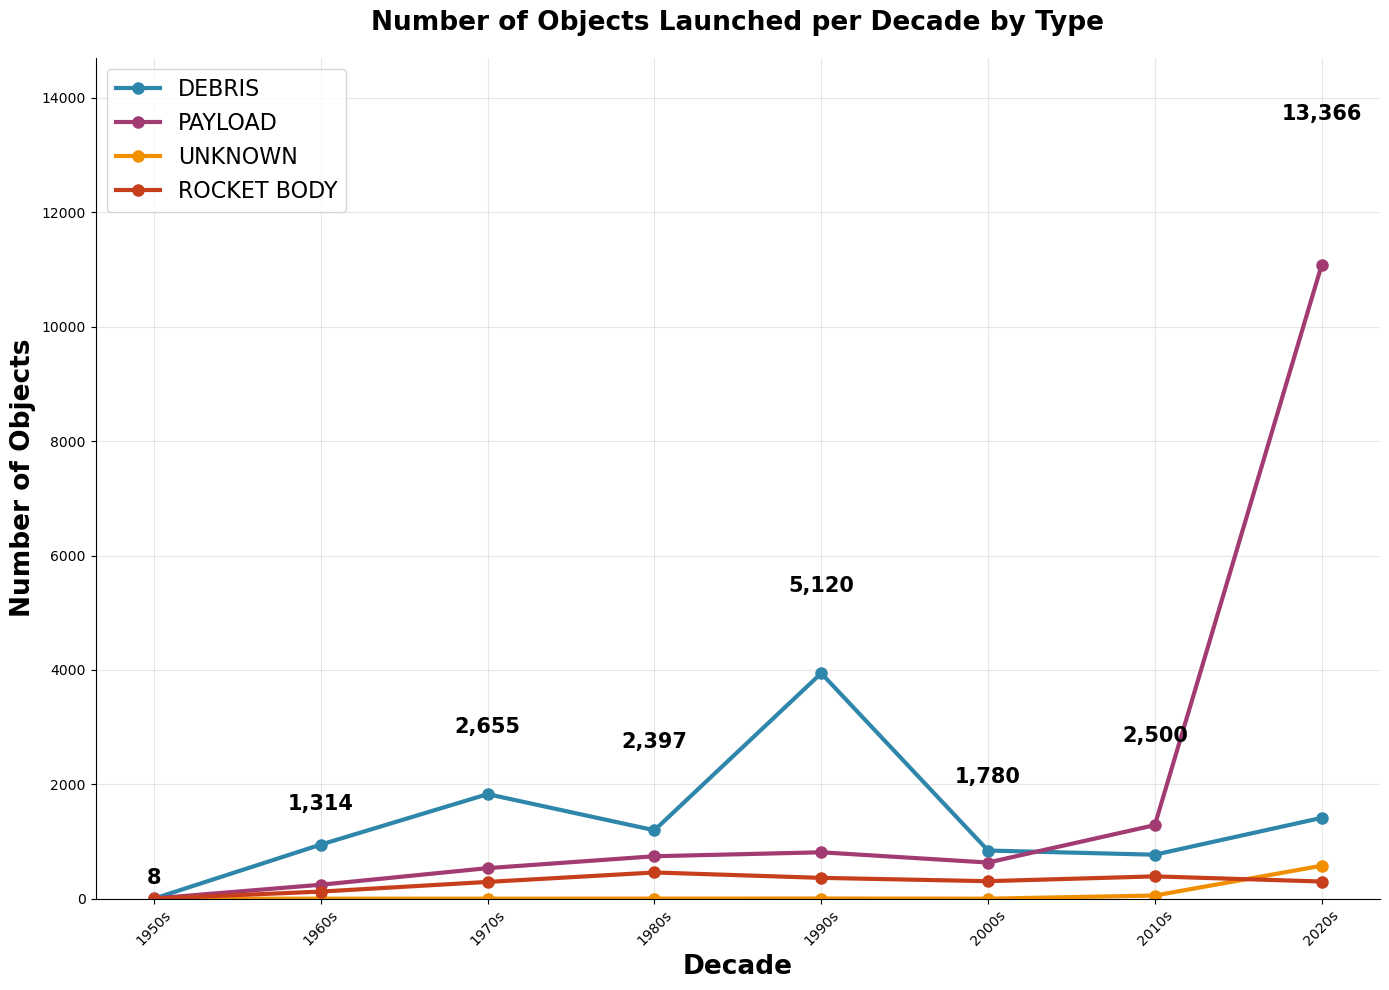

In [43]:
import matplotlib.pyplot as plt
import pandas as pd

# Create the visualization
plt.figure(figsize=(14, 10))

# Define decades
decades = ['1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s', '2020s']

# Get unique object types
object_types = df_sat['object_type'].unique()

# Define colors for each object type
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']

# Plot line for each object type
for i, obj_type in enumerate(object_types):
    # Filter data for this object type
    obj_data = df_sat[df_sat['object_type'] == obj_type]
    
    # Count objects per decade
    decade_counts = []
    for decade in decades:
        count = obj_data['launch_decade'].value_counts().get(decade, 0)
        decade_counts.append(count)
    
    # Create line plot for this object type
    plt.plot(decades, decade_counts, marker='o', linewidth=3, markersize=8, 
             color=colors[i % len(colors)], label=obj_type)

# Add value annotations on each point for the total (optional)
total_counts = []
for decade in decades:
    count = df_sat['launch_decade'].value_counts().get(decade, 0)
    total_counts.append(count)

for i, count in enumerate(total_counts):
    plt.annotate(f'{count:,}', 
                 (decades[i], total_counts[i]), 
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center',
                 fontweight='bold', fontsize=15)

# Customize the plot
plt.title('Number of Objects Launched per Decade by Type', fontsize=19, fontweight='bold', pad=20)
plt.xlabel('Decade', fontsize=19, fontweight='bold')
plt.ylabel('Number of Objects', fontsize=19, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Add legend
plt.legend(loc='upper left', fontsize=16)

# Set y-axis to start from 0
plt.ylim(0, max(total_counts) * 1.1)

# Add some styling
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

Let's zoom in and create a visualization focusing on Payload within the period from 2016 to 2020s with a year-by-year breakdown.

Payload is of high interest as these are actual functioning satellites or spacecrafts designed to perform a specific mission

Examples:

- Communication satellites (Starlink, GPS, TV broadcast)

- Weather satellites

- Earth observation satellites

- Scientific research satellites

- Military reconnaissance satellites

Purpose: These are the "working" objects in space that provide services or collect data

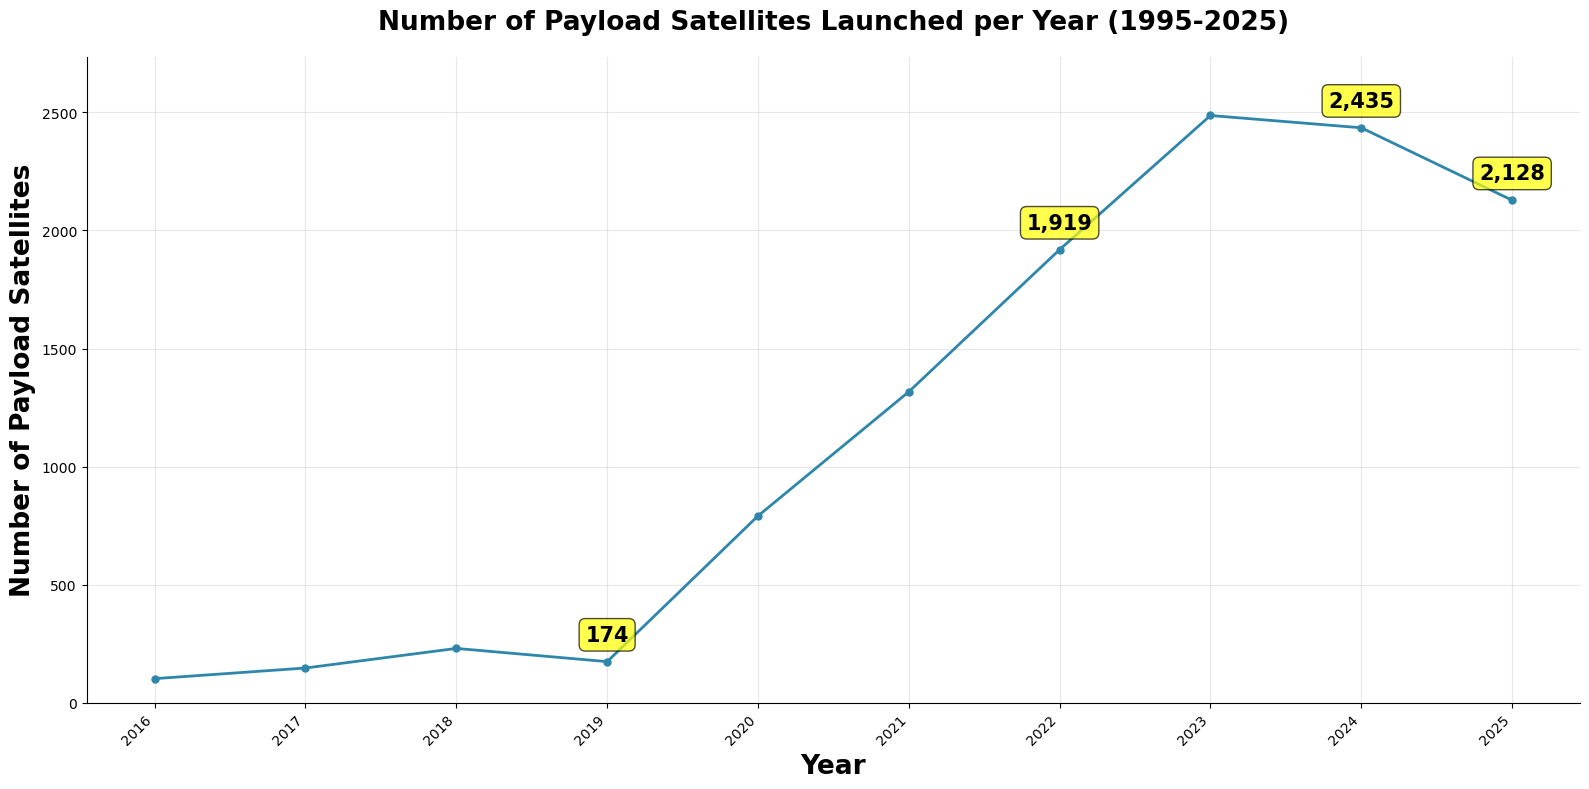

In [84]:

# Filter data for Payload objects from 2016 to 2025
payload_years = df_sat[(df_sat['launch_year'] >= 2016) & 
                       (df_sat['object_type'] == 'Payload')]

# Get value counts for each year
yearly_counts = payload_years['launch_year'].value_counts().sort_index()

# Create the visualization
plt.figure(figsize=(16, 8))

# Extract years and counts
years = [str(year) for year in yearly_counts.index]
counts = yearly_counts.values

# Create line plot
line = plt.plot(years, counts, marker='o', linewidth=2, markersize=5, color='#2E86AB')

# List of years to annotate
years_to_annotate = ['2019', '2022', '2024', '2025']

# Add value annotations only for specified years
for i, (year_str, count) in enumerate(zip(years, counts)):
    if year_str in years_to_annotate:
        plt.annotate(f'{count:,}', 
                     (year_str, count), 
                     textcoords="offset points", 
                     xytext=(0,15), 
                     ha='center',
                     fontsize=15,
                     fontweight='bold',
                     bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

# Customize the plot
plt.title('Number of Payload Satellites Launched per Year (1995-2025)', 
          fontsize=19, fontweight='bold', pad=20)
plt.xlabel('Year', fontsize=19, fontweight='bold')
plt.ylabel('Number of Payload Satellites', fontsize=19, fontweight='bold')
plt.grid(True, alpha=0.3)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Set y-axis to start from 0
if len(counts) > 0:
    plt.ylim(0, max(counts) * 1.1)
else:
    plt.ylim(0, 100)  # Default range if no data

# Add some styling
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

# Viz: Launch by countries

In [45]:
df_sat['country'].value_counts().sort_values(ascending=False)

country
US      14337
CIS      5800
PRC      5379
UK        720
FR        557
        ...  
FRIT        1
BELA        1
TMMC        1
SVN         1
BOL         1
Name: count, Length: 104, dtype: int64

In [88]:
import pandas as pd
import plotly.express as px

# Get top countries
top_countries = df_sat['country'].value_counts().head(10)

# Create custom labels that include both country and count
labels = [f"{country}<br>{count}" for country, count in zip(top_countries.index, top_countries.values)]

# Create treemap
fig = px.treemap(
    names=labels,
    parents=['World' for _ in top_countries.index],
    values=top_countries.values,
    title='Proportion of Space Objects by Country (Top 10)'
)

fig.update_traces(
    textinfo='label+value+percent parent',
    texttemplate='<b>%{label}</b><br>Count: %{value}<br>%{percentParent} of total',
    hovertemplate='<b>%{label}</b><br>Count: %{value}<br>Percentage: %{percentParent:.1%}',
)

fig.show()

# Viz: governmental vs private

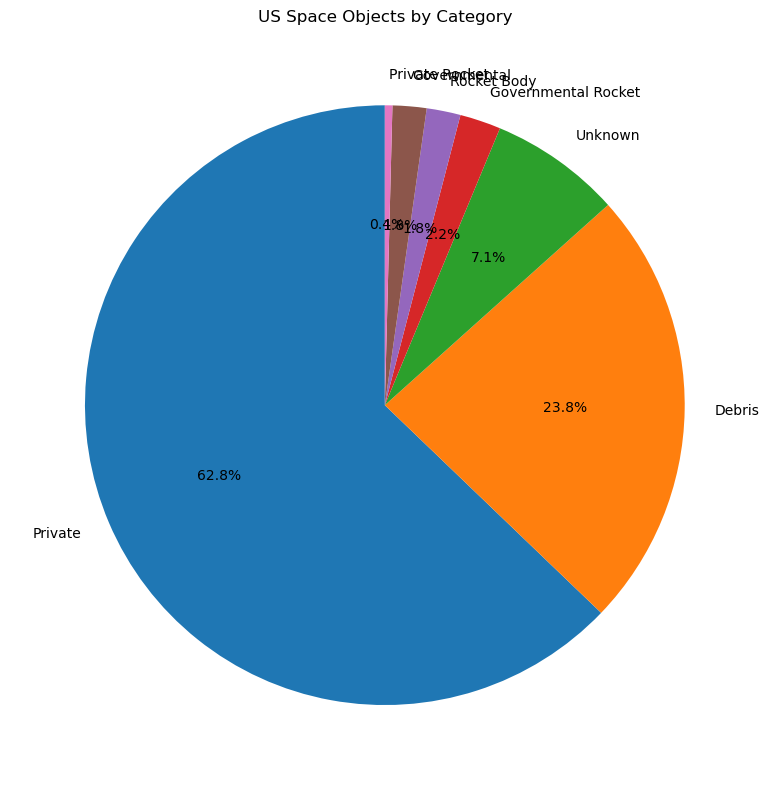

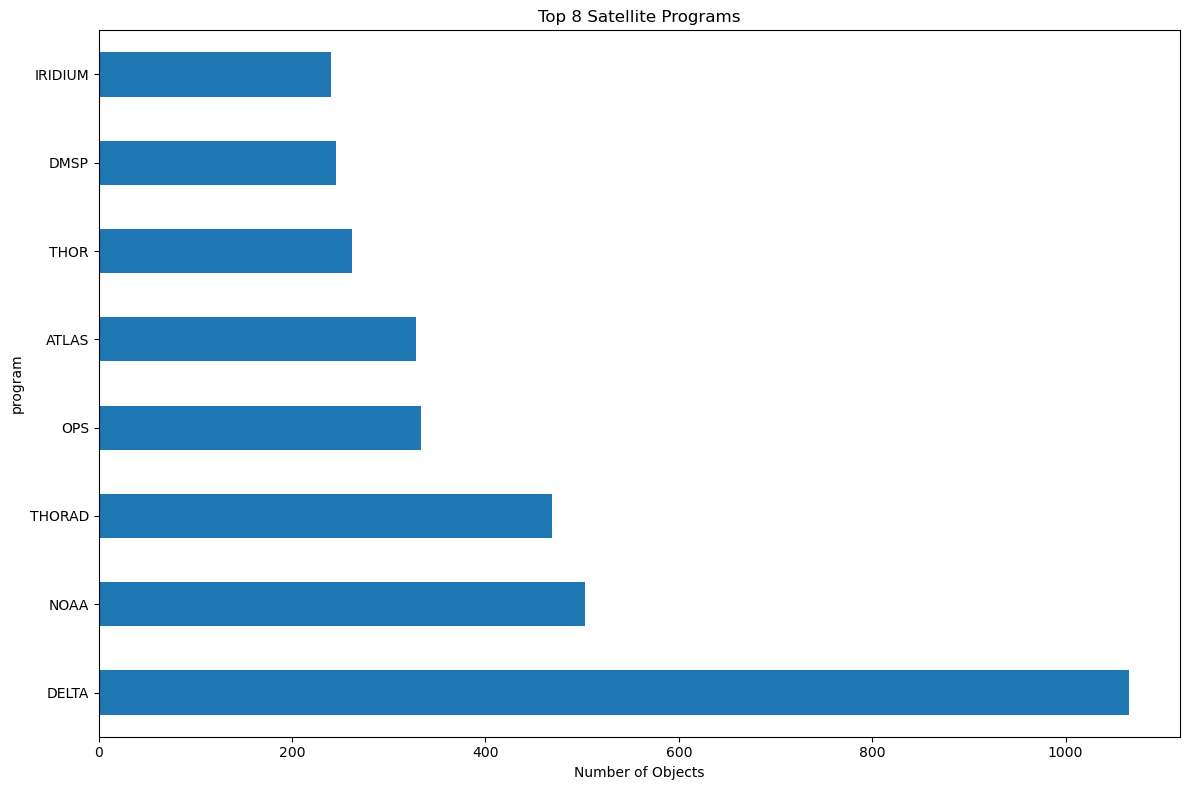

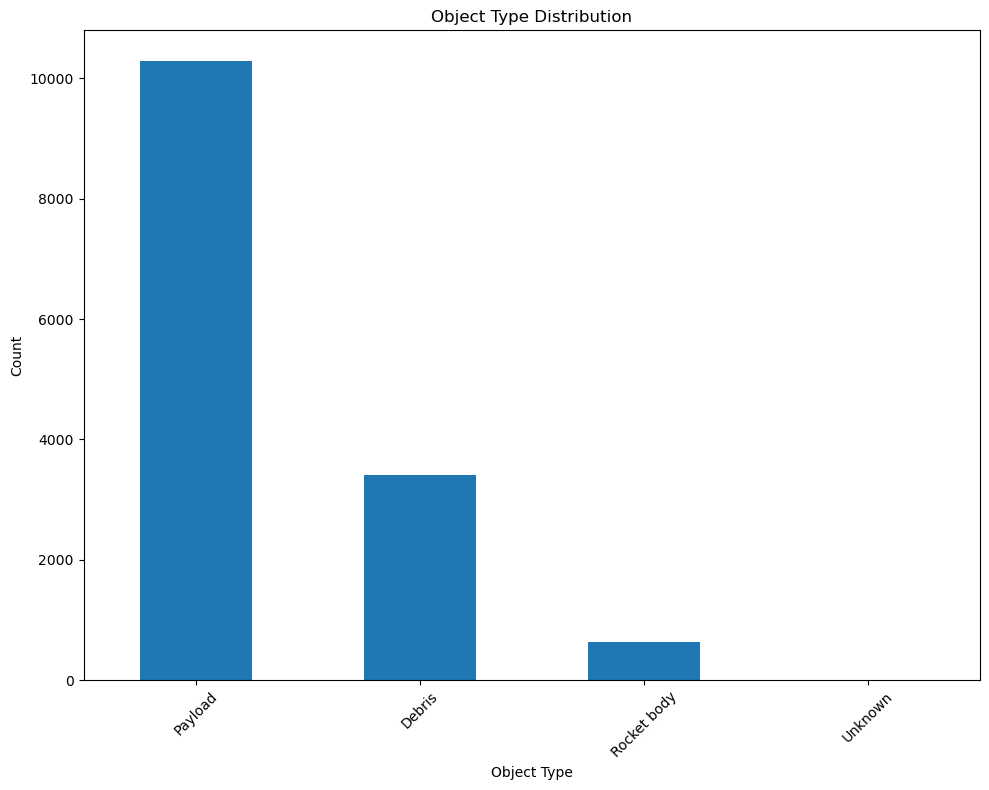

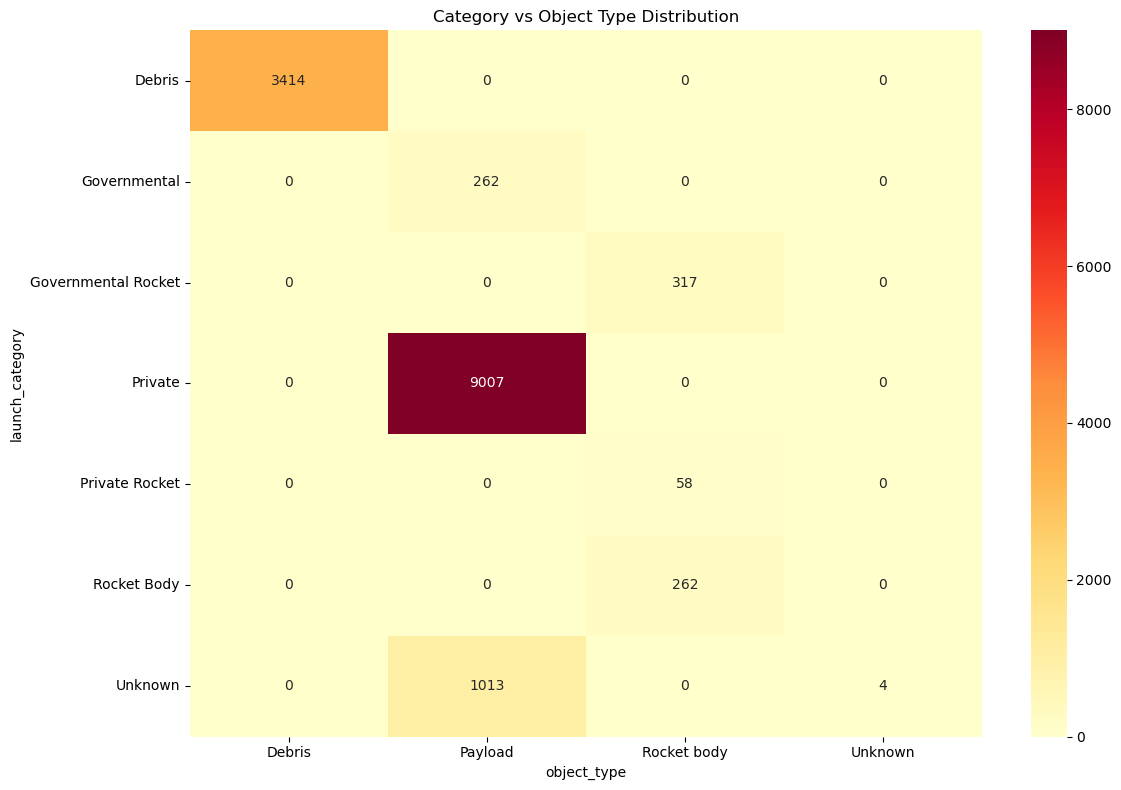

<Figure size 1400x1000 with 0 Axes>

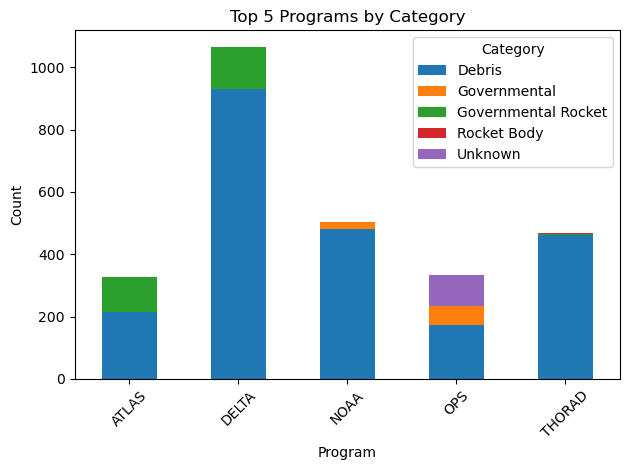

✅ Analysis complete!
📊 Total objects analyzed: 14,337
📁 Detailed results saved to: us_space_objects_detailed_analysis.csv
🖼️  Visualizations saved as separate PNG files


In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filter US objects
us_objects = df_sat[df_sat['country'] == 'US'].copy()

# --- REFINED CATEGORIZATION ---
# Let's improve the keyword lists based on common US space objects

governmental_keywords = [
    'NOAA', 'DMSP', 'GPS', 'GOES', 'LANDSAT', 'EOS', 'TDRS', 
    'MODIS', 'ICESAT', 'JASON', 'GRACE', 'SUOMI', 'AQUA', 'TERRA',
    'CYGNSS', 'DSCS', 'WGS', 'SBIRS', 'NROL', 'MILSTAR',
    'DEFENSE', 'TITAN', 'MERURY', 'MISTY', 'PAN', 'TRUMPET',
    'VANGUARD', 'EXPLORER', 'BLAZAR', 'TEMPLAR', 'LACROSSE', 'INTRUDER',
    'DSP', 'NAVSTAR', 'WEATHER', 'EARTH', 'CLOUDSAT', 'CALIPSO',
    'SORCE', 'AURA', 'QUIKSCAT', 'SEAWIFS', 'TERRIERS'
]

private_keywords = [
    'STARLINK', 'SPACEX', 'PLANET', 'SKYSAT', 'FLOCK', 'DOVE',
    'LEMUR', 'GLOBALSTAR', 'ORBCOMM', 'KEPLER', 'SWARM',
    'ASTROCAST', 'CAPELLA', 'ICEYE', 'UMBRA', 'BLACKSKY',
    'GHOST', 'HYPERION', 'LIGHTSAIL', 'SKYFI', 'SPIRE', 'TELEOS',
    'IRIDIUM', 'GLOBALSTAR', 'ORBCOMM', 'ECHOSTAR', 'DIRECTV',
    'SIRIUS', 'XM', 'RADIOSAT', 'ASIASTAR', 'GALAXY', 'INTELSAT',
    'EUTELSAT', 'AMC', 'SATMEX', 'THURAYA', 'INMARSAT'
]

# Enhanced categorization function
def categorize_launch(name, object_type):
    if pd.isna(name):
        return 'Unknown'
    
    name_str = str(name).upper()
    
    # Check for rocket bodies first
    if object_type == 'Rocket body':
        if any(keyword in name_str for keyword in ['ATLAS', 'DELTA', 'TITAN', 'MINOTAUR']):
            return 'Governmental Rocket'
        elif any(keyword in name_str for keyword in ['FALCON', 'ANTARES']):
            return 'Private Rocket'
        return 'Rocket Body'
    
    # Check for debris
    if object_type == 'Debris':
        return 'Debris'
    
    # Governmental keywords
    for keyword in governmental_keywords:
        if keyword in name_str:
            return 'Governmental'
    
    # Private keywords
    for keyword in private_keywords:
        if keyword in name_str:
            return 'Private'
    
    # Special cases for common patterns
    if 'STARLINK' in name_str:
        return 'Private'
    if any(word in name_str for word in ['R/B', 'Rocket', 'Debris', 'DEB']):
        return 'Debris/Other'
    
    return 'Unknown'

# Apply enhanced categorization
us_objects['launch_category'] = us_objects.apply(
    lambda row: categorize_launch(row['satname'], row['object_type']), 
    axis=1
)

# --- ANALYSIS ---
category_counts = us_objects['launch_category'].value_counts()
total_objects = len(us_objects)
us_objects['program'] = us_objects['satname'].apply(
    lambda x: str(x).split()[0] if pd.notna(x) and str(x).strip() != '' else 'Unknown'
)
top_programs = us_objects['program'].value_counts().head(10)

# --- SEPARATE VISUALIZATIONS ---

# 1. Pie chart of categories
plt.figure(figsize=(10, 8))
category_counts.plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('US Space Objects by Category')
plt.ylabel('')
plt.tight_layout()
plt.savefig('us_space_objects_pie_chart.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Bar chart of top programs
plt.figure(figsize=(12, 8))
top_programs.head(8).plot(kind='barh')
plt.title('Top 8 Satellite Programs')
plt.xlabel('Number of Objects')
plt.tight_layout()
plt.savefig('us_top_programs_bar_chart.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Object type distribution
plt.figure(figsize=(10, 8))
us_objects['object_type'].value_counts().head(6).plot(kind='bar')
plt.title('Object Type Distribution')
plt.xlabel('Object Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('us_object_type_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Additional visualization: Category by object type (heatmap)
plt.figure(figsize=(12, 8))
category_object_cross = pd.crosstab(us_objects['launch_category'], us_objects['object_type'])
sns.heatmap(category_object_cross, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Category vs Object Type Distribution')
plt.tight_layout()
plt.savefig('us_category_object_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Additional visualization: Top programs by category
plt.figure(figsize=(14, 10))
top_5_programs = top_programs.head(5).index
program_category_data = us_objects[us_objects['program'].isin(top_5_programs)]
program_category_cross = pd.crosstab(program_category_data['program'], program_category_data['launch_category'])
program_category_cross.plot(kind='bar', stacked=True)
plt.title('Top 5 Programs by Category')
plt.xlabel('Program')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Category')
plt.tight_layout()
plt.savefig('us_top_programs_by_category.png', dpi=300, bbox_inches='tight')
plt.show()

# --- SAVE DETAILED RESULTS ---
output_file = 'us_space_objects_detailed_analysis.csv'
us_objects.to_csv(output_file, index=False)

print(f"✅ Analysis complete!")
print(f"📊 Total objects analyzed: {total_objects:,}")
print(f"📁 Detailed results saved to: {output_file}")
print(f"🖼️  Visualizations saved as separate PNG files")

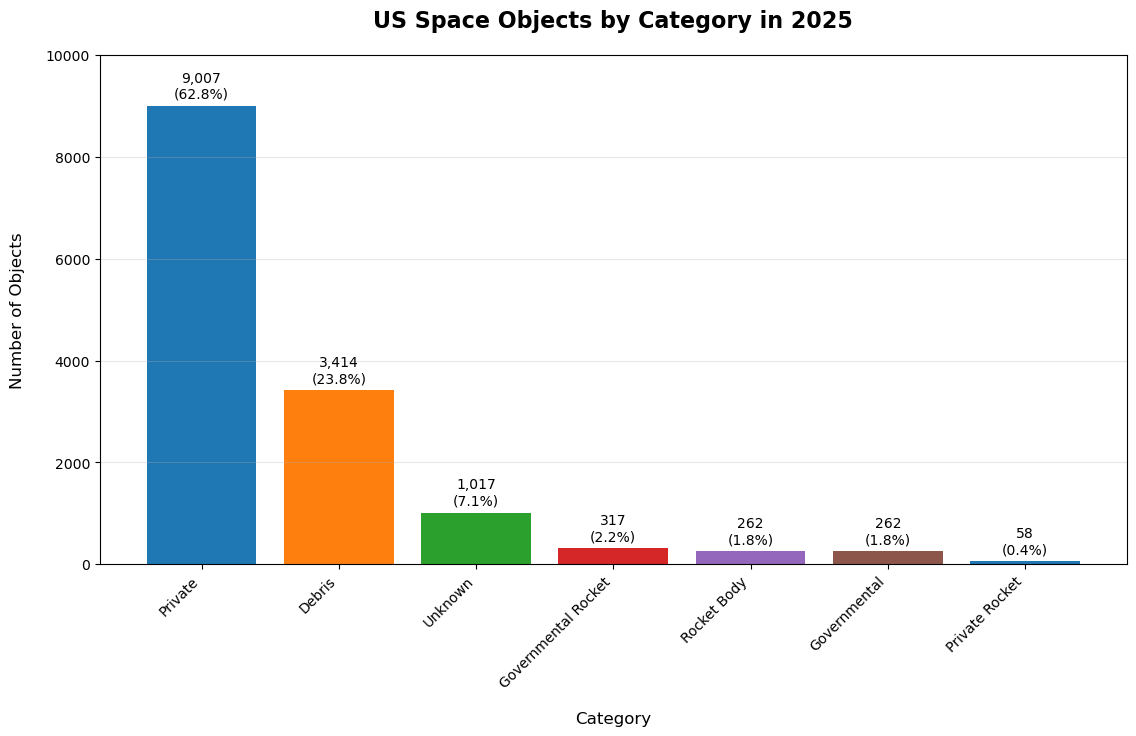

In [106]:
# 1. Bar chart of categories with y-axis limit changed
plt.figure(figsize=(12, 8))
bars = plt.bar(category_counts.index, category_counts.values, 
               color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'])
plt.title('US Space Objects by Category in 2025', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Category', fontsize=12, labelpad=15)
plt.ylabel('Number of Objects', fontsize=12, labelpad=15)
plt.xticks(rotation=45, ha='right')

# Set y-axis limit to 10000
plt.ylim(0, 10000)

# Add value labels on top of bars
for i, v in enumerate(category_counts.values):
    percentage = (v / total_objects) * 100
    plt.text(i, v + max(category_counts.values)*0.01, 
             f'{v:,}\n({percentage:.1f}%)', 
             ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout(pad=3.0)
plt.savefig('us_space_objects_bar_chart.png', dpi=300, bbox_inches='tight')
plt.show()

### Assign Orbit Classes to Each Object

1. Prep data by creating new perigee and apogee columns. Need to account for Earth's radius already being included in the elset apogee and perigee columns.
2. Flag rows with vast differences in perigee and apogee across datasets after account for Earth's radius.
3. Create new categorical column with the orbit class for each object.

In [46]:
EARTH_RADIUS = 6378.137  # km (WGS84 equatorial radius)
df_sat["perigee_alt_km"] = df_sat["perigee_els"] - EARTH_RADIUS
df_sat["apogee_alt_km"]  = df_sat["apogee_els"]  - EARTH_RADIUS


In [47]:
df_check = df_sat[['satNo', 'perigee_sat', 'apogee_sat', 'perigee_alt_km', 'apogee_alt_km']].copy()
df_check['apogee_diff'] = df_check['apogee_sat'] - df_check['apogee_alt_km']
df_check['perigee_diff'] = df_check['perigee_sat'] - df_check['perigee_alt_km']
df_check[['apogee_diff', 'perigee_diff']].describe()

,apogee_diff,perigee_diff
count,29103.000000,29103.000000
mean,-1.505660,3.501992
std,248.867713,623.350550
min,-13836.053000,-18832.942000
25%,-1.051000,-0.961000
50%,-0.113000,-0.172000
75%,0.405000,0.457000
max,31497.941000,102451.756000


In [48]:
df_check[df_check['apogee_diff'].abs() > 100].sort_values(by='apogee_diff', ascending=False)

,satNo,perigee_sat,apogee_sat,perigee_alt_km,apogee_alt_km,apogee_diff,perigee_diff
8791844,59228,314973.0,638523.0,300864.064,607025.059,31497.941,14108.936
9424361,39459,78179.0,460746.0,87904.856,443233.507,17512.493,-9725.856
9119261,43435,123504.0,335955.0,117918.953,333626.197,2328.803,5585.047
9361498,837,49238.0,156751.0,50454.034,155541.132,1209.868,-1216.034
9311024,674,50536.0,167187.0,51631.031,166116.286,1070.714,-1095.031
...,...,...,...,...,...,...,...
9406687,63158,118.0,2485.0,108.588,8626.123,-6141.123,9.412
8755973,37755,58963.0,296547.0,77795.942,303550.707,-7003.707,-18832.942
8760921,60058,148603.0,437008.0,144033.018,444017.202,-7009.202,4569.982
7773795,57770,227890.0,298108.0,125438.244,308387.709,-10279.709,102451.756


In [49]:
apogee_mismatch = df_check[df_check['apogee_diff'].abs() > 200]['satNo']
perigee_mismatch = df_check[df_check['perigee_diff'].abs() > 200]['satNo']
df_sat['apogee_mismatch'] = df_sat['satNo'].isin(apogee_mismatch)
df_sat['perigee_mismatch'] = df_sat['satNo'].isin(perigee_mismatch)
print('Objects with apogee mismatch between elset data and satellite catalog: ',  df_sat['apogee_mismatch'].sum())
print('Objects with perigee mismatch between elset data and satellite catalog: ', df_sat['perigee_mismatch'].sum())

Objects with apogee mismatch between elset data and satellite catalog:  80
Objects with perigee mismatch between elset data and satellite catalog:  47


In [50]:
# drop duplicate columns
df_sat = df_sat.drop(columns=['apogee_sat', 'perigee_sat', 'apogee_els', 'perigee_els', 'period_sat'])

In [51]:
df_sat['perigee_alt_km'].describe()

count     29109.000000
mean       3311.684659
std        9232.091124
min        -218.163000
25%         494.306000
50%         637.345000
75%         924.623000
max      300864.064000
Name: perigee_alt_km, dtype: float64

In [52]:
df_sat[df_sat['perigee_alt_km'] > 35786]

,argOfPerigee,bStar,createdAt,eccentricity,semiMajorAxis,satNo,revNo,raan,period_els,meanMotionDot,meanMotionDDot,meanMotion,meanAnomaly,inclination_els,idOnOrbit,epoch,epoch_date,intldes,norad_cat_id,object_type,satname,country,launch,site,decay,inclination_sat,rcsvalue,rcs_size,file,launch_year,launch_num,launch_piece,object_name,object_id,object_number,launch_decade,perigee_alt_km,apogee_alt_km,apogee_mismatch,perigee_mismatch
6817454,77.3100,0.0,2025-06-01 23:07:57.174000+00:00,0.478972,118085.757,1459,4724,10.7885,6730.634,-1.638000e-05,0.0,0.213947,359.1419,41.1385,1459,2025-06-05 21:51:56.298528+00:00,2025-06-05,1965-058B,1459,PAYLOAD,OPS 6564 (VELA 6),US,1965-07-20,AFETR,NaN,41.15,0,NaN,9204,1965,58,B,OPS 6564 (VELA 6),1965-058B,1459,1960s,55147.861,168267.379,False,False
7263010,214.1037,0.0,2025-06-12 23:07:45.793000+00:00,0.561497,115743.495,692,4975,44.9241,6531.375,-1.215000e-05,0.0,0.220474,359.8474,26.4185,692,2025-06-16 23:56:12.566688+00:00,2025-06-16,1963-039C,692,PAYLOAD,VELA 1,US,1963-10-17,AFETR,NaN,27.98,0,LARGE,9230,1963,39,C,VELA 1,1963-039C,692,1960s,44375.744,174354.972,True,True
7567223,106.2819,0.0,2025-06-19 15:07:54.170000+00:00,0.465431,118552.398,2766,4546,12.5797,6770.570,-1.518000e-05,0.0,0.212685,358.6899,34.3846,2766,2025-06-23 20:20:07.323936+00:00,2025-06-23,1967-040B,2766,PAYLOAD,OPS 6679 (VELA 8),US,1967-04-28,AFETR,NaN,34.38,0,NaN,9202,1967,40,B,OPS 6679 (VELA 8),1967-040B,2766,1960s,56996.276,167352.245,False,False
7773795,294.0371,0.0,2025-07-01 19:08:02.658000+00:00,0.409666,223291.114,57770,43,3.0372,17501.162,-3.581000e-05,0.0,0.082280,359.8283,33.9343,57770,2025-06-27 12:38:30.285888+00:00,2025-06-27,2023-098C,57770,PAYLOAD,CH 3 PROPULSION MODULE,IND,2023-07-14,SRI,NaN,34.48,0,NaN,9237,2023,98,C,CH 3 PROPULSION MODULE,2023-098C,57770,2020s,125438.244,308387.709,True,True
8091510,222.1863,0.0,2025-07-07 23:07:54.905000+00:00,0.005719,43628.664,43513,2507,177.4520,1511.533,-1.010000e-06,0.0,0.952675,137.0417,1.0584,43513,2025-07-04 18:45:37.102752+00:00,2025-07-04,1969-013R,43513,DEBRIS,TITAN 3C TRANSTAGE DEB,US,1969-02-09,AFETR,NaN,1.07,0,NaN,9240,1969,13,R,TITAN 3C TRANSTAGE DEB,1969-013R,43513,1960s,37000.997,37500.057,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9492270,177.1928,0.0,2025-08-03 18:07:56.769000+00:00,0.001099,42506.467,32293,1223,79.7541,1453.591,-1.200000e-06,0.0,0.990650,177.0523,3.9314,32293,2025-08-03 12:46:16.166784+00:00,2025-08-03,2007-056A,32293,PAYLOAD,STAR ONE C1,BRAZ,2007-11-14,FRGUI,NaN,4.00,0,LARGE,9240,2007,56,A,STAR ONE C1,2007-056A,32293,2000s,36081.594,36175.066,False,False
9490244,40.8075,0.0,2025-08-04 04:07:52.337000+00:00,0.000138,42246.557,25897,9481,15.0076,1440.279,7.500000e-07,0.0,0.999806,316.6255,13.4376,25897,2025-08-03 12:46:38.866656+00:00,2025-08-03,1999-047B,25897,PAYLOAD,YAMAL 102,CIS,1999-09-06,TTMTR,NaN,13.46,0,LARGE,9240,1999,47,B,YAMAL 102,1999-047B,25897,1990s,35862.607,35874.233,False,False
9486229,30.7062,0.0,2025-08-03 18:07:51.067000+00:00,0.007788,42951.329,9803,2155,287.0537,1476.470,-8.300000e-07,0.0,0.975299,132.0331,5.5411,9803,2025-08-03 12:50:38.248224+00:00,2025-08-03,1977-007A,9803,PAYLOAD,OPS 3151,US,1977-02-06,AFETR,NaN,5.48,0,NaN,9237,1977,7,A,OPS 3151,1977-007A,9803,1970s,36238.704,36907.679,False,False
9485398,350.5812,0.0,2025-08-03 18:07:50.610000+00:00,0.002015,42766.836,5204,20311,292.2550,1466.967,-1.000000e-06,0.0,0.981617,167.5107,0.6051,5204,2025-08-03 12:50:38.248224+00:00,2025-08-03,1971-039A,5204,PAYLOAD,OPS 3811,US,1971-05-05,AFETR,NaN,0.55,0,NaN,9240,1971,39,A,OPS 3811,1971-039A,5204,1970s,36302.541,36474.857,False,False


In [53]:
def classify_orbit(perigee_km, apogee_km, eccentricity):
    """Classify orbit based on perigee, apogee, and eccentricity."""
    if pd.isna(perigee_km) or pd.isna(apogee_km):
        return 'Unknown'
    # GEO band check (both near GEO altitude)
    if (abs(perigee_km - 35786) <= 200) and (abs(apogee_km - 35786) <= 200):
        return 'GEO'
    # HEO check
    if eccentricity > 0.1 and (apogee_km - perigee_km) > 10000:
        return 'HEO'
    # LEO / MEO otherwise
    if perigee_km < 2000:
        return 'LEO'
    if perigee_km < 35786:
        return 'MEO'
    return 'HEO'

df_sat['orbit_class'] = df_sat.apply(lambda row: classify_orbit(row['perigee_alt_km'], row['apogee_alt_km'], row['eccentricity']), axis=1)
df_sat['orbit_class'].value_counts()

orbit_class
LEO        24872
HEO         2473
MEO          887
GEO          877
Unknown       31
Name: count, dtype: int64

In [54]:
df_sat['orbit_class'].value_counts(normalize=True) * 100

orbit_class
LEO        85.353466
HEO         8.486616
MEO         3.043926
GEO         3.009609
Unknown     0.106383
Name: proportion, dtype: float64

# Classes of orbits by object counts

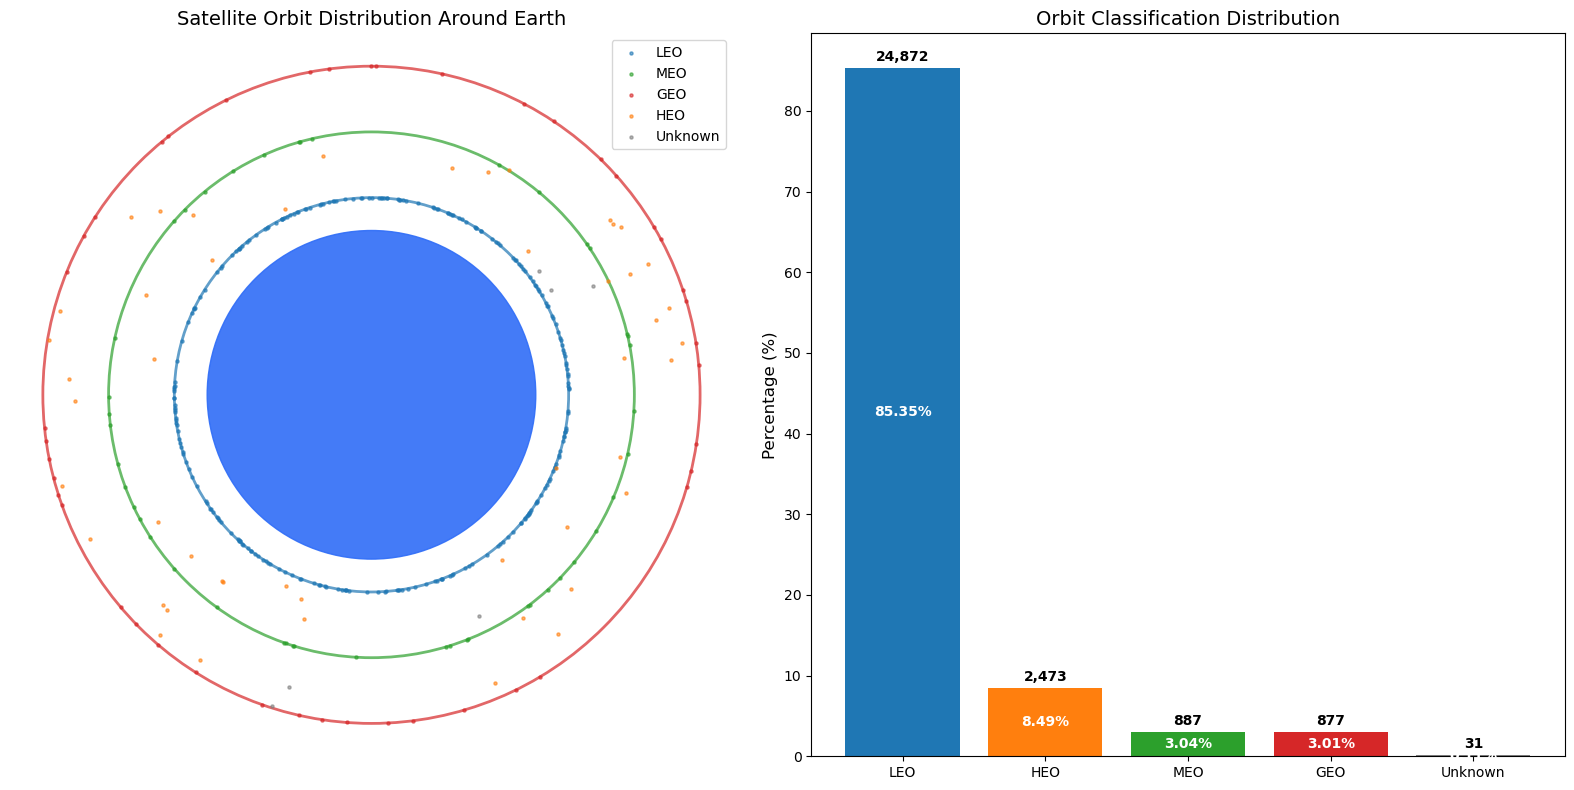

In [55]:
from matplotlib.patches import Circle

orbit_classes = ['LEO', 'HEO', 'MEO', 'GEO', 'Unknown']
counts = [24872, 2473, 887, 877, 31]
percentages = [85.35, 8.49, 3.04, 3.01, 0.11]

# Colors for each orbit class
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#7f7f7f']

# Create figure and axis
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# First subplot: Earth with orbit rings
# Draw Earth
earth = Circle((0, 0), 1, color='#2F6DF7', alpha=0.9)
ax[0].add_patch(earth)

# Orbit radii (normalized)
leo_radius = 1.2
meo_radius = 1.6
geo_radius = 2.0

# Draw orbit rings
leo_ring = Circle((0, 0), leo_radius, fill=False, color=colors[0], linestyle='-', linewidth=2, alpha=0.7)
meo_ring = Circle((0, 0), meo_radius, fill=False, color=colors[2], linestyle='-', linewidth=2, alpha=0.7)
geo_ring = Circle((0, 0), geo_radius, fill=False, color=colors[3], linestyle='-', linewidth=2, alpha=0.7)

ax[0].add_patch(leo_ring)
ax[0].add_patch(meo_ring)
ax[0].add_patch(geo_ring)

# Add scatter points to represent satellites
np.random.seed(42)  # For reproducible random points

# LEO points
leo_theta = np.random.uniform(0, 2*np.pi, int(counts[0]/100))  # Scaling down for visualization
leo_x = leo_radius * np.cos(leo_theta)
leo_y = leo_radius * np.sin(leo_theta)
ax[0].scatter(leo_x, leo_y, color=colors[0], s=5, alpha=0.6, label='LEO')

# MEO points
meo_theta = np.random.uniform(0, 2*np.pi, int(counts[2]/20))  # Scaling down
meo_x = meo_radius * np.cos(meo_theta)
meo_y = meo_radius * np.sin(meo_theta)
ax[0].scatter(meo_x, meo_y, color=colors[2], s=5, alpha=0.6, label='MEO')

# GEO points
geo_theta = np.random.uniform(0, 2*np.pi, int(counts[3]/20))  # Scaling down
geo_x = geo_radius * np.cos(geo_theta)
geo_y = geo_radius * np.sin(geo_theta)
ax[0].scatter(geo_x, geo_y, color=colors[3], s=5, alpha=0.6, label='GEO')

# HEO points (elliptical orbits)
heo_theta = np.random.uniform(0, 2*np.pi, int(counts[1]/50))  # Scaling down
heo_r = leo_radius + (geo_radius - leo_radius) * np.random.random(len(heo_theta))
heo_x = heo_r * np.cos(heo_theta)
heo_y = heo_r * np.sin(heo_theta)
ax[0].scatter(heo_x, heo_y, color=colors[1], s=5, alpha=0.6, label='HEO')

# Unknown points
unknown_theta = np.random.uniform(0, 2*np.pi, int(counts[4]/5))  # Scaling down
unknown_r = leo_radius + (geo_radius - leo_radius) * np.random.random(len(unknown_theta))
unknown_x = unknown_r * np.cos(unknown_theta)
unknown_y = unknown_r * np.sin(unknown_theta)
ax[0].scatter(unknown_x, unknown_y, color=colors[4], s=5, alpha=0.6, label='Unknown')

# Set aspect ratio and limits
ax[0].set_aspect('equal')
ax[0].set_xlim(-2.2, 2.2)
ax[0].set_ylim(-2.2, 2.2)
ax[0].set_title('Satellite Orbit Distribution Around Earth', fontsize=14)
ax[0].legend(loc='upper right')
ax[0].axis('off')

# Second subplot: Bar chart with percentages and counts
bars = ax[1].bar(orbit_classes, percentages, color=colors)
ax[1].set_ylabel('Percentage (%)', color='black', fontsize=12)
ax[1].set_title('Orbit Classification Distribution', fontsize=14)
ax[1].tick_params(axis='y', labelcolor='black')

# Add count labels on top of bars
for i, (bar, count) in enumerate(zip(bars, counts)):
    height = bar.get_height()
    ax[1].text(bar.get_x() + bar.get_width()/2., height + 0.5,
               f'{count:,}', ha='center', va='bottom', fontweight='bold')

# Add percentage labels inside bars
for i, (bar, percentage) in enumerate(zip(bars, percentages)):
    height = bar.get_height()
    ax[1].text(bar.get_x() + bar.get_width()/2., height/2,
               f'{percentage}%', ha='center', va='center', color='white', fontweight='bold')

plt.tight_layout()
plt.show()

### Clean object types and look at relationship with orbit classes

In [56]:
df_sat['object_type'].value_counts()

object_type
PAYLOAD        15330
DEBRIS         10938
ROCKET BODY     2237
UNKNOWN          635
Name: count, dtype: int64

In [57]:
df_sat["object_type"] = df_sat["object_type"].str.capitalize()
df_sat["object_type"].value_counts()


object_type
Payload        15330
Debris         10938
Rocket body     2237
Unknown          635
Name: count, dtype: int64

In [58]:
pivot = df_sat.pivot_table(index='object_type', columns='orbit_class', values='satNo', aggfunc='nunique', fill_value=0)
pivot

orbit_class,GEO,HEO,LEO,MEO,Unknown
object_type,,,,,
Debris,12,970,9774,164,18
Payload,796,674,13396,453,11
Rocket body,69,828,1070,269,1
Unknown,0,1,632,1,1


In [59]:
pivot_percent_rows = pivot.div(pivot.sum(axis=1), axis=0) * 100
pivot_percent_rows

orbit_class,GEO,HEO,LEO,MEO,Unknown
object_type,,,,,
Debris,0.109709,8.868166,89.358201,1.499360,0.164564
Payload,5.192433,4.396608,87.384214,2.954990,0.071755
Rocket body,3.084488,37.013858,47.831918,12.025034,0.044703
Unknown,0.000000,0.157480,99.527559,0.157480,0.157480


In [60]:
pivot_percent_cols = pivot.div(pivot.sum(axis=0), axis=1) * 100
pivot_percent_cols

orbit_class,GEO,HEO,LEO,MEO,Unknown
object_type,,,,,
Debris,1.368301,39.223615,39.297202,18.489290,58.064516
Payload,90.763968,27.254347,53.859762,51.071026,35.483871
Rocket body,7.867731,33.481601,4.302026,30.326945,3.225806
Unknown,0.000000,0.040437,2.541010,0.112740,3.225806


### Create launch year bins

In [61]:
df_sat['launch_year'].value_counts().sort_index()

launch_year
1958       3
1959       5
1960      11
1961     210
1962      25
        ... 
2021    1408
2022    2728
2023    2701
2024    3376
2025    2321
Name: count, Length: 68, dtype: int64

In [62]:
lauch_year_dict = {'1950s': range(1950, 1960),
                   '1960s': range(1960, 1970),
                   '1970s': range(1970, 1980),
                   '1980s': range(1980, 1990),
                   '1990s': range(1990, 2000),
                   '2000s': range(2000, 2010),
                   '2010s': range(2010, 2020),
                   '2020s': range(2020, 2030)}

def classify_launch_year(year):
    if pd.isna(year): return "Unknown"
    for decade, years in lauch_year_dict.items():
        if year in years:
            return decade
    return "Unknown"    

df_sat['launch_decade'] = df_sat['launch_year'].apply(classify_launch_year)
df_sat['launch_decade'].value_counts().sort_index()

launch_decade
1950s        8
1960s     1314
1970s     2655
1980s     2397
1990s     5120
2000s     1780
2010s     2500
2020s    13366
Name: count, dtype: int64

# Launch by decades (as a trend) and years (1990s-2020s) viz

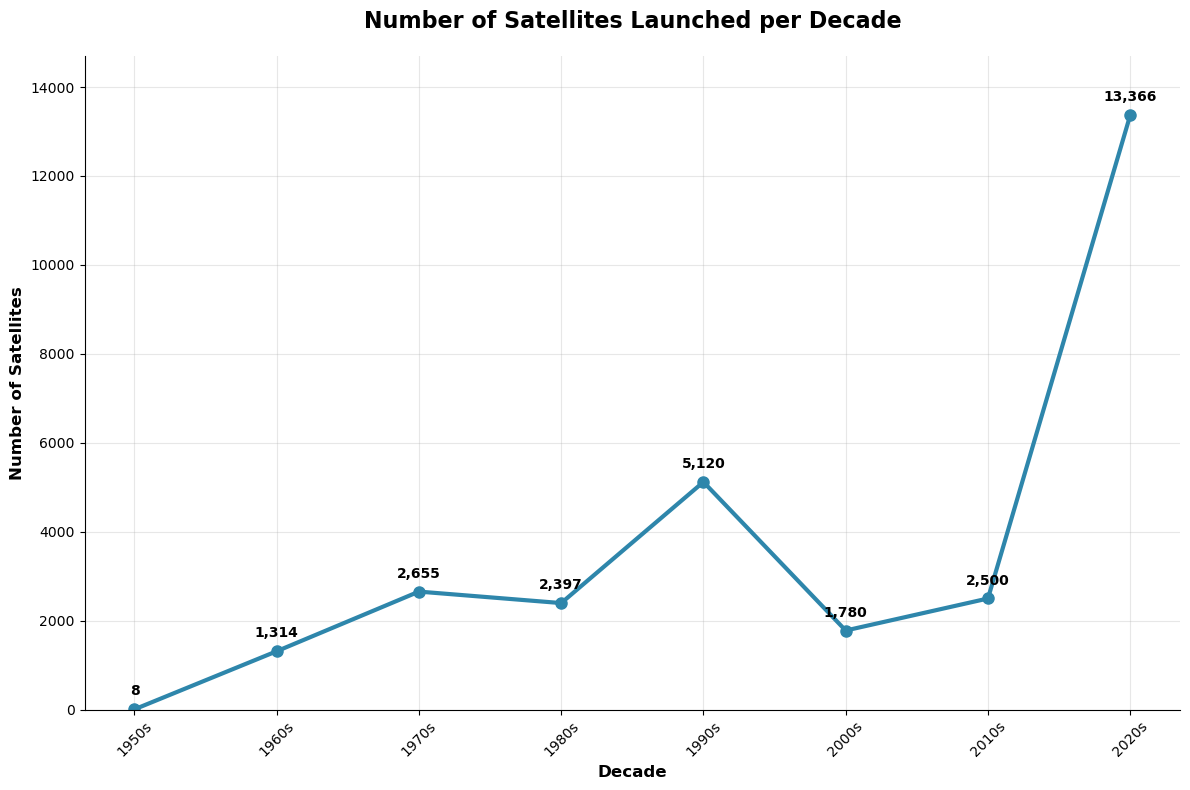

In [63]:
# Create the visualization
plt.figure(figsize=(12, 8))

decades = ['1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s', '2020s']
satellite_counts = [8,  # 1958-1959
                   df_sat['launch_decade'].value_counts().sort_index().get('1960s', 0),
                   df_sat['launch_decade'].value_counts().sort_index().get('1970s', 0),
                   df_sat['launch_decade'].value_counts().sort_index().get('1980s', 0),
                   df_sat['launch_decade'].value_counts().sort_index().get('1990s', 0),
                   df_sat['launch_decade'].value_counts().sort_index().get('2000s', 0),
                   df_sat['launch_decade'].value_counts().sort_index().get('2010s', 0),
                   df_sat['launch_decade'].value_counts().sort_index().get('2020s', 0)]

# Create line plot
line = plt.plot(decades, satellite_counts, marker='o', linewidth=3, markersize=8, color='#2E86AB')

# Add value annotations on each point
for i, count in enumerate(satellite_counts):
    plt.annotate(f'{count:,}', 
                 (decades[i], satellite_counts[i]), 
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center',
                 fontweight='bold')

# Customize the plot
plt.title('Number of Satellites Launched per Decade', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Decade', fontsize=12, fontweight='bold')
plt.ylabel('Number of Satellites', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Set y-axis to start from 0
plt.ylim(0, max(satellite_counts) * 1.1)

# Add some styling
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

In [64]:
df_sat[df_sat['object_type'] == 'Debris']['launch_decade'].value_counts().sort_index()

launch_decade
1950s       2
1960s     946
1970s    1828
1980s    1196
1990s    3942
2000s     842
2010s     769
2020s    1413
Name: count, dtype: int64

### Assign inclination bands
**Why we calculate it**
- Inclination tells you a satellite’s tilt relative to Earth’s equator.
- Binning it makes orbital planes easy to compare and helps explain traffic corridors (equatorial vs polar vs retrograde planes).
- Conjunction risk is very plane-dependent: crowded planes (e.g., sun-sync near ~98°) see more potential close approaches.

**What it’s useful for**
- Identify which planes are congested.
- Compare operators/constellations by plane.
- Drive heatmaps (altitude shell × inclination band) to show “where the highways are.”

**How to interpret the categories**
- Equatorial (0–30°): GEO and near-equatorial LEO/MEO users; low lat coverage, great for fixed ground links.
- Mid (30–60°): Mixed users; broad coverage without going polar.
- Polar/Sun-sync (60–90°): Earth-observation heavy.
- Retrograde (>90°): Orbits going opposite Earth rotation; rarer, fuel-expensive; can cross other traffic → interesting for risk.

In [65]:
def inclination_band(deg):
    if pd.isna(deg): return "Unknown"
    if deg < 30:     return "Equatorial (0–30°)"
    if deg < 60:     return "Mid (30–60°)"
    if deg <= 90:   return "Polar/Sun-sync (60–90°)"
    return "Retrograde (>90°)"

df_sat["inclination_band"] = df_sat["inclination_els"].apply(inclination_band)
df_sat["inclination_band"].value_counts()

inclination_band
Mid (30–60°)               9116
Retrograde (>90°)          8609
Polar/Sun-sync (60–90°)    8131
Equatorial (0–30°)         3284
Name: count, dtype: int64

### Assign Elliptical Class

**Why we calculate it**
- Eccentricity describes how stretched the orbit is.
- Highly elliptical orbits sweep through multiple altitude shells, touching regions that circular LEOs never visit → different risk profile and drag behavior.

**What it’s useful for**
- Separate circular constellations (Starlink/OneWeb, GEO) from transfer/HEO users (GTO, Molniya, Tundra).
- Explain why some bands have transient traffic (HEO perigees pass through then depart).
- Decide which objects belong in a perigee-based shell analysis.

**How to interpret the categories**
- Near-Circular (<0.01): Constellations and GEO; stable altitude → persistent congestion within a shell.
- Elliptical (0.01–0.10): Transfers or specialized missions; moderate shell crossing.
- Highly Elliptical (≥0.10): Big apogee/perigee swings; spend long time near apogee, dip through perigee shells quickly → they touch many shells but don’t dwell there.

In [66]:
def ecc_class(e):
    if pd.isna(e): return "Unknown"
    if e < 0.01:   return "Near-Circular (<0.01)"
    if e < 0.10:   return "Elliptical (0.01–0.10)"
    return "Highly Elliptical (≥0.10)"

df_sat["ecc_class"] = df_sat["eccentricity"].apply(ecc_class)
df_sat["ecc_class"].value_counts()

ecc_class
Near-Circular (<0.01)        22616
Elliptical (0.01–0.10)        4266
Highly Elliptical (≥0.10)     2258
Name: count, dtype: int64

### Assign object age

In [67]:
# age in years (rough)
now_year = pd.Timestamp.utcnow().year
df_sat["age_years"] = np.where(df_sat["launch_year"].notna(),
                               now_year - df_sat["launch_year"], np.nan)
df_sat["age_years"].describe()

count    29140.000000
mean        18.880302
std         19.184087
min          0.000000
25%          2.000000
50%         10.000000
75%         33.000000
max         67.000000
Name: age_years, dtype: float64

### Assign shell category

In [68]:
SHELL_SIZE = 100  # km
# Clamp perigee at 0+ to avoid negative bins; set very high perigees to a cap if desired
perig = df_sat['perigee_alt_km'].clip(lower=0)

# Integer shell index (0=0–99 km, 1=100–199 km, …)
df_sat["shell_idx_100km"] = (perig // SHELL_SIZE).astype("Int64")

# Human-readable label
def shell_label(idx):
    if pd.isna(idx): return "Unknown"
    lo = int(idx) * SHELL_SIZE
    hi = lo + SHELL_SIZE - 1
    return f"{lo:>4d}–{hi:>4d} km"

df_sat["shell_100km"] = df_sat["shell_idx_100km"].apply(shell_label)

# shell center altitude (useful for density approximations)
df_sat["shell_center_km"] = df_sat["shell_idx_100km"].astype("float") * SHELL_SIZE + SHELL_SIZE/2


In [69]:
df_sat['shell_center_km'].describe()

count     29109.000000
mean       3307.703803
std        9231.486427
min          50.000000
25%         450.000000
50%         650.000000
75%         950.000000
max      300850.000000
Name: shell_center_km, dtype: float64

### Assign decay vs orbiting flags

In [70]:
# use decay date to identify decayed vs. currently orbiting
df_sat["is_decayed"] = df_sat["decay"].notna()
df_sat["is_current_orbiting"] = ~df_sat["is_decayed"] 

### Identify Constellation Objects

**Why we calculate it**
- Mega-constellations dominate LEO growth and shape congestion patterns.
- Flagging them lets you quantify their share of a shell/plane and compare payload vs debris contexts.

**What it’s useful for**
- Attribute congestion in a shell/plane to specific operators.
- Show temporal growth (by launch year/decade) of constellations.
- Support a policy/sustainability slide (e.g., “X% of this corridor is Starlink payloads; debris ratio is Y.”)

**How to interpret the flags**
- is_starlink/oneweb/iridium = True → member of that constellation family.
- is_constellation = True → belongs to at least one tracked constellation set.
- Extendable: add flags for GLOBALSTAR, ORBCOMM, GALILEO, GLONASS, BEIDOU if helpful.

In [71]:
# constellation flags
name_upper = df_sat["satname"].str.upper().fillna("")
df_sat["is_starlink"]  = name_upper.str.contains("STARLINK",  na=False)
df_sat["is_oneweb"]    = name_upper.str.contains("ONEWEB",    na=False)
df_sat["is_iridium"]   = name_upper.str.contains("IRIDIUM",   na=False)
df_sat["is_constellation"] = df_sat[["is_starlink","is_oneweb","is_iridium"]].any(axis=1)


## Shell Summary

**Why we calculate it**
- You need a clear, comparable view of where objects cluster in altitude.
- Shells are the backbone for “crowdedness” charts and for picking bands to zoom in with conjunction analysis.
- Perigee is a conservative proxy for drag & interaction: an object with perigee in a shell passes through that band every orbit.

**What it’s useful for**
- Rank shells by n_objects to find hot corridors (e.g., 540–640 km).
- Compute debris-to-payload ratios per shell → “dirty vs clean” corridors.
- Build heatmaps with inclination_band to show where congestion concentrates by plane.
- Choose target shells for your near-miss (conjunction) analysis.

**How to interpret the categories/measures**
- High n_objects in a shell ⇒ more persistent congestion there.
- High debris/payload ratio in a shell ⇒ higher risk profile and sustainability concern.
- shell_center_km ≈ representative altitude for that band; useful when normalizing by path length (circumference) to compare bands.

✅ Together, these features give you two strong analytical levers:
- Where is it busiest? (n_objects, linear density)
- Where is it dirtiest? (debris/payload ratio)

*Notes*
- 100 km is a good default; 50 km reveals finer structure (e.g., distinct “Starlink shells”).
- Perigee bins are conservative; if you want the “dwelling altitude” view, add a second set of apogee or mean altitude bins and compare.

In [72]:
pi = math.pi

# aggregate by 100-km shell
shell_grp = (df_sat[df_sat["shell_idx_100km"].notna()]
             .groupby("shell_100km", dropna=False)
            )

shell_summary = shell_grp.agg(
    n_objects      = ("satNo", "count"),
    n_payloads     = ("object_type", lambda s: (s=="Payload").sum()),
    n_debris       = ("object_type", lambda s: (s=="Debris").sum()),
    n_rocket       = ("object_type", lambda s: (s=="Rocket Body").sum()),
    n_constellation= ("is_constellation","sum"),
    mean_incl      = ("inclination_els","mean"),
    median_incl    = ("inclination_els","median"),
    mean_ecc       = ("eccentricity","mean")
).reset_index()

# debris-to-payload ratio (avoid div-by-zero)
shell_summary["debris_payload_ratio"] = shell_summary["n_debris"] / shell_summary["n_payloads"].replace({0:np.nan})

# simple circumference-based "linear density" proxy:
# objects per 100-km shell circumference at shell center altitude
# NOTE: this is a heuristic for relative congestion, not physics-accurate flux
def shell_center_from_label(lbl):
    lo = int(lbl.split("–")[0])
    hi = int(lbl.split("–")[1].split()[0])
    return (lo + hi) / 2

shell_summary["shell_center_km"] = shell_summary["shell_100km"].apply(shell_center_from_label)
shell_summary["orbital_circumference_km"] = 2 * pi * (EARTH_RADIUS + shell_summary["shell_center_km"])
shell_summary["objects_per_10k_km"] = shell_summary["n_objects"] / (shell_summary["orbital_circumference_km"] / 10_000.0)

# helpful sort for reporting
shell_summary = shell_summary.sort_values("n_objects", ascending=False)


In [73]:
shell_summary

,shell_100km,n_objects,n_payloads,n_debris,n_rocket,n_constellation,mean_incl,median_incl,mean_ecc,debris_payload_ratio,shell_center_km,orbital_circumference_km,objects_per_10k_km
5,500– 599 km,6271,4977,972,0,4237,62.661138,53.21730,0.021591,0.195298,549.5,43527.627012,1440.694205
4,400– 499 km,4681,3808,434,0,2965,60.111232,53.15910,0.026817,0.113971,449.5,42899.308481,1091.15978
7,700– 799 km,3286,405,2712,0,156,87.306752,98.22275,0.025656,6.696296,749.5,44784.264073,733.739868
8,800– 899 km,2285,262,1919,0,0,86.650439,98.65970,0.029306,7.324427,849.5,45412.582604,503.164513
6,600– 699 km,2203,390,1665,0,54,85.263085,97.95620,0.048107,4.269231,649.5,44155.945543,498.91356
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,125400–125499 km,1,1,0,0,0,33.934300,33.93430,0.409666,0.000000,125449.5,828297.471879,0.012073
36,14200–14299 km,1,0,0,0,0,8.706600,8.70660,0.338111,NaN,14249.5,129607.265720,0.077156
34,13800–13899 km,1,0,0,0,0,7.047900,7.04790,0.345410,NaN,13849.5,127093.991597,0.078682
33,13500–13599 km,1,0,0,0,0,124.705600,124.70560,0.005538,NaN,13549.5,125209.036005,0.079866


### Dwelling Altitude View
**Why we calculate it**
- The perigee-based shell view shows where an orbit dips down to — useful for flagging potential crossings and drag/lifetime effects.
- But many orbits (especially elliptical) spend most of their time far from perigee, near apogee, because orbital speed slows there.
- A dwelling view shows where satellites actually spend most of their orbital time, which is important for:
- Traffic density analysis → where the “population in space” is concentrated.
- Collision probability estimates → higher where objects linger.
- Complementing perigee view → “crossing risk vs dwelling congestion.”

**What the calculation consists of**

We’ll start with a simple proxy, which is enough for EDA:
1. Mean altitude proxy:
    - dwelling_alt_km = (apogee_alt_km + perigee_alt_km) / 2
    - Averages perigee and apogee → better than just using perigee.
    - Approximates the “center of gravity” of the orbit.
2. Optional weighted proxy (closer to orbital mechanics):
    - Satellites spend proportionally more time near apogee.
    - A slightly better approximation is to bias the average toward apogee:
    - dwelling_alt_km ≈ (2*apogee + perigee) / 3
    - (This comes from Kepler’s second law: area swept out per unit time is constant, so slower speeds near apogee = longer dwell).

**What it’s useful for**
- Complementary view to perigee shells:
    - Perigee → “which shells get crossed.”
    - Dwelling → “where satellites spend their orbital lifetime.”
- Lets you rank congested bands differently:
    - Some high-apogee, elliptical orbits won’t appear congested in perigee bins (because they just “dip through”) but show up clearly in dwelling bins.
    - Helps you separate real density from transient crossings.

**How to interpret the measures / categories**
- dwelling_alt_km ~500–600 km → Starlink and other mega-constellations; persistent congestion.
- dwelling_alt_km ~20,000 km → GNSS constellations (GPS, Galileo, GLONASS, BeiDou).
- dwelling_alt_km ~35,786 km → GEO belt; satellites stay nearly fixed relative to Earth.
- dwelling_alt_km ~10,000–20,000 km elliptical → Molniya/Tundra-type missions → appear in different shells than their perigee dips.

In charts:
- You may see far fewer “low-altitude” satellites in the dwelling view vs perigee view → that’s correct, because those elliptical orbits only skim the lower shells briefly.
- High-apogee shells look busier, because satellites spend most of their time up there.

✅ Summary:
- Perigee view = “crossing corridors” → conservative for collision risk.
- Dwelling view = “residency bands” → realistic traffic density.
- Using both together gives you a strong, nuanced analysis: “Here’s where orbits cross dangerously, and here’s where they actually linger.”

In [74]:
# Simple mean altitude proxy
df_sat["dwelling_alt_km"] = (df_sat["apogee_alt_km"] + df_sat["perigee_alt_km"]) / 2

# Weighted proxy (2x apogee, 1x perigee) – optional
df_sat["dwelling_alt_km_weighted"] = (2*df_sat["apogee_alt_km"] + df_sat["perigee_alt_km"]) / 3

# Bin into 100 km shells, same as perigee view
SHELL_SIZE = 100
df_sat["dwelling_shell_idx"] = (df_sat["dwelling_alt_km"] // SHELL_SIZE).astype("Int64")

def shell_label(idx):
    if pd.isna(idx): return "Unknown"
    lo = int(idx) * SHELL_SIZE
    hi = lo + SHELL_SIZE - 1
    return f"{lo:>4d}–{hi:>4d} km"

df_sat["dwelling_shell_100km"] = df_sat["dwelling_shell_idx"].apply(shell_label)


In [75]:
# --- Perigee-based shell summary ---
perigee_summary = (df_sat[df_sat["shell_100km"].notna()]
    .groupby("shell_100km")
    .agg(
        n_objects_perigee=("satNo","count"),
        n_payloads_perigee=("object_type", lambda s: (s=="Payload").sum()),
        n_debris_perigee=("object_type", lambda s: (s=="Debris").sum())
    )
)

# --- Dwelling-based shell summary ---
dwelling_summary = (df_sat[df_sat["dwelling_shell_100km"].notna()]
    .groupby("dwelling_shell_100km")
    .agg(
        n_objects_dwelling=("satNo","count"),
        n_payloads_dwelling=("object_type", lambda s: (s=="Payload").sum()),
        n_debris_dwelling=("object_type", lambda s: (s=="Debris").sum())
    )
)

# --- Merge side by side ---
shell_compare = (perigee_summary
    .merge(dwelling_summary, left_index=True, right_index=True, how="outer")
    .fillna(0)
    .reset_index()
    .rename(columns={"index":"shell_band"})
)

# --- Add ratios for interpretation ---
shell_compare["debris_payload_ratio_perigee"] = (
    shell_compare["n_debris_perigee"] /
    shell_compare["n_payloads_perigee"].replace({0:np.nan})
)
shell_compare["debris_payload_ratio_dwelling"] = (
    shell_compare["n_debris_dwelling"] /
    shell_compare["n_payloads_dwelling"].replace({0:np.nan})
)

# Example: view top 15 shells by perigee vs dwelling counts
shell_compare.sort_values("n_objects_perigee", ascending=False).head(15)


,shell_band,n_objects_perigee,n_payloads_perigee,n_debris_perigee,n_objects_dwelling,n_payloads_dwelling,n_debris_dwelling,debris_payload_ratio_perigee,debris_payload_ratio_dwelling
5,500– 599 km,6271,4977.0,972.0,5652,4987.0,372.0,0.195298,0.074594
4,400– 499 km,4681,3808.0,434.0,4132,3681.0,145.0,0.113971,0.039391
7,700– 799 km,3286,405.0,2712.0,2596,407.0,2037.0,6.696296,5.004914
8,800– 899 km,2285,262.0,1919.0,2642,237.0,2283.0,7.324427,9.632911
6,600– 699 km,2203,390.0,1665.0,1536,417.0,1009.0,4.269231,2.419664
3,300– 399 km,1455,1006.0,247.0,1105,941.0,105.0,0.245527,0.111583
9,900– 999 km,1167,314.0,638.0,1666,336.0,1118.0,2.031847,3.327381
74,1400–1499 km,1048,507.0,436.0,925,564.0,311.0,0.859961,0.551418
1,100– 199 km,853,629.0,46.0,750,610.0,20.0,0.073132,0.032787
296,35700–35799 km,726,674.0,14.0,765,709.0,19.0,0.020772,0.026798


#### 🔍 Interpretation of perigee vs dwelling views
- Rows where perigee >> dwelling

    → Orbits just pass through this band (crossing corridor).\
    → Example: elliptical orbits dipping into LEO but dwelling higher.\
    “1,000 km shell looks busy if you count perigee crossings, but in reality few satellites dwell here.”
- Rows where dwelling >> perigee\
    → Satellites live in this band.\
    → Example: GNSS at ~20,000 km, GEO at 35,786 km.\
    “20,000 km shell shows the true density of GPS/Galileo, even though perigee view underplays it.”
- Debris/payload ratio differences\
    → Some shells look debris-heavy when using perigee crossings but not when dwelling.\
    “At 1,000 km, debris dominates crossings, but dwelling view shows it’s not a true congestion zone.”

### 🌍 Hotspot Pivot: Altitude Shell × Inclination Band

**Why we calculate it**
- We want to see where orbital traffic concentrates, not just by altitude but also by orbital plane.
- Altitude shells (vertical dimension) + inclination bands (horizontal dimension) give a 2D map of congestion.
- This helps identify “orbital highways” (e.g., Starlink at ~550 km polar/Sun-sync, GNSS at ~20,000 km mid-inclination, GEO equatorial belt).

**About the pivot table**
- Pivot table: counts objects (satNo) for each altitude shell × inclination band combination.
- Rows = altitude shells (e.g., 500–599 km).
- Columns = inclination categories (Equatorial, Polar/Sun-sync, etc.).
- Cells = how many satellites are in that shell and inclination band.

**What it’s useful for**
- Quickly reveals which altitude bands are busiest and in which orbital planes.
- Lets you zoom in:
    - “The 500–600 km shell is dominated by polar/Sun-sync payloads (Starlink, Earth observation).”
    - “GEO (~35,700 km) is dense but purely equatorial.”
- Great for visual storytelling: a heatmap of this pivot table makes an instant impact.

**How to interpret the output**
- Rows with large totals → altitude bands with the most traffic overall.
- Column dominance in a row → tells you which orbital planes dominate that altitude:
- Mostly Polar/Sun-sync → Earth observation and polar constellations.
- Mostly Equatorial → GEO or equatorial LEO.
- Mix of bands → diverse operators sharing the band.
- Outliers: shells with unexpected retrograde populations → possible special missions or misaligned debris.

In [76]:
# build pivot table of objects per altitude shell × inclination band
hotspots = (df_sat
    .dropna(subset=["shell_100km"])
    .pivot_table(
        index="shell_100km",
        columns="inclination_band",
        values="satNo",
        aggfunc="count",
        fill_value=0
    )
)

# sort by total count across all inclination bands
hotspots["total"] = hotspots.sum(axis=1)
hotspots = hotspots.sort_values("total", ascending=False)

# drop the helper column if you want a clean table
hotspots_no_total = hotspots.drop(columns=["total"])
hotspots

inclination_band,Equatorial (0–30°),Mid (30–60°),Polar/Sun-sync (60–90°),Retrograde (>90°),total
shell_100km,,,,,
500– 599 km,161,3738,1025,1347,6271
400– 499 km,123,3156,361,1041,4681
700– 799 km,58,102,1412,1714,3286
800– 899 km,51,66,860,1308,2285
600– 699 km,103,121,690,1289,2203
...,...,...,...,...,...
14200–14299 km,1,0,0,0,1
144000–144099 km,1,0,0,0,1
14700–14799 km,1,0,0,0,1


In [77]:
hotspots_no_total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 280 entries,  500– 599 km to 77700–77799 km
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Equatorial (0–30°)       280 non-null    Int64
 1   Mid (30–60°)             280 non-null    Int64
 2   Polar/Sun-sync (60–90°)  280 non-null    Int64
 3   Retrograde (>90°)        280 non-null    Int64
dtypes: Int64(4)
memory usage: 12.0+ KB


In [78]:
def top_shells_by_objects(k=10):
    cols = ["shell_100km","n_objects","n_payloads","n_debris","debris_payload_ratio","objects_per_10k_km"]
    return shell_summary.sort_values("n_objects", ascending=False).loc[:, cols].head(k)

def top_starlink_shells(k=10):
    t = (df_sat[df_sat["is_starlink"]]
         .groupby("shell_100km", dropna=False)["satNo"].count()
         .sort_values(ascending=False)
         .rename("n_starlink")
         .reset_index())
    return t.head(k)

def debris_heavy_shells(threshold=1.0, k=10):
    t = shell_summary[shell_summary["debris_payload_ratio"] >= threshold]
    return t.sort_values("debris_payload_ratio", ascending=False).head(k)


In [79]:
top_shells_by_objects(10)

,shell_100km,n_objects,n_payloads,n_debris,debris_payload_ratio,objects_per_10k_km
5,500– 599 km,6271,4977,972,0.195298,1440.694205
4,400– 499 km,4681,3808,434,0.113971,1091.15978
7,700– 799 km,3286,405,2712,6.696296,733.739868
8,800– 899 km,2285,262,1919,7.324427,503.164513
6,600– 699 km,2203,390,1665,4.269231,498.91356
3,300– 399 km,1455,1006,247,0.245527,344.207695
9,900– 999 km,1167,314,638,2.031847,253.470278
35,1400–1499 km,1048,507,436,0.859961,213.083949
1,100– 199 km,853,629,46,0.073132,207.975974
180,35700–35799 km,726,674,14,0.020772,27.427717


In [80]:
top_starlink_shells(5)

,shell_100km,n_starlink
0,500– 599 km,4221
1,400– 499 km,2961
2,300– 399 km,832
3,100– 199 km,452
4,200– 299 km,59


In [81]:
debris_heavy_shells(1.0, 10)

,shell_100km,n_objects,n_payloads,n_debris,n_rocket,n_constellation,mean_incl,median_incl,mean_ecc,debris_payload_ratio,shell_center_km,orbital_circumference_km,objects_per_10k_km
265,8700–8799 km,17,1,14,0,0,19.804941,13.05710,0.478877,14.000000,8749.5,95049.746531,1.788537
261,8300–8399 km,13,1,12,0,0,12.152915,12.99460,0.472131,12.000000,8349.5,92536.472408,1.404851
260,8200–8299 km,12,1,10,0,0,18.254458,13.46655,0.482413,10.000000,8249.5,91908.153877,1.305651
251,7400–7499 km,10,1,9,0,0,24.358950,19.75490,0.498339,9.000000,7449.5,86881.605631,1.150992
171,34900–34999 km,14,1,8,0,0,6.612171,7.52330,0.014120,8.000000,34949.5,259669.201579,0.539147
8,800– 899 km,2285,262,1919,0,0,86.650439,98.65970,0.029306,7.324427,849.5,45412.582604,503.164513
262,8400–8499 km,17,2,14,0,0,19.422065,13.07640,0.475804,7.000000,8449.5,93164.790939,1.824724
144,3200–3299 km,13,1,7,0,0,63.624300,68.73670,0.354946,7.000000,3249.5,60492.227341,2.149036
7,700– 799 km,3286,405,2712,0,156,87.306752,98.22275,0.025656,6.696296,749.5,44784.264073,733.739868
41,1500–1599 km,112,17,89,0,0,88.516747,102.03550,0.033371,5.235294,1549.5,49810.812319,22.485078


In [82]:
df_sat.head()

,argOfPerigee,bStar,createdAt,eccentricity,semiMajorAxis,satNo,revNo,raan,period_els,meanMotionDot,meanMotionDDot,meanMotion,meanAnomaly,inclination_els,idOnOrbit,epoch,epoch_date,intldes,norad_cat_id,object_type,satname,country,launch,site,decay,inclination_sat,rcsvalue,rcs_size,file,launch_year,launch_num,launch_piece,object_name,object_id,object_number,launch_decade,perigee_alt_km,apogee_alt_km,apogee_mismatch,perigee_mismatch,orbit_class,inclination_band,ecc_class,age_years,shell_idx_100km,shell_100km,shell_center_km,is_decayed,is_current_orbiting,is_starlink,is_oneweb,is_iridium,is_constellation,dwelling_alt_km,dwelling_alt_km_weighted,dwelling_shell_idx,dwelling_shell_100km
31636,158.0519,0.071972,2025-01-01 16:05:13.461000+00:00,0.002807,6694.428,60773,2104,332.9594,90.851,0.123356,0.274000,15.850119,202.1971,88.9702,60773,2025-01-01 05:40:21.204192+00:00,2025-01-01,2024-140EY,60773,Debris,CZ-6A DEB,PRC,2024-08-06,TSC,2025-01-06,88.97,0,SMALL,9003,2024,140,EY,CZ-6A DEB,2024-140EY,60773,2020s,297.499,335.083,False,False,LEO,Polar/Sun-sync (60–90°),Near-Circular (<0.01),1.0,2,200– 299 km,250.0,True,False,False,False,False,False,316.2910,322.555000,3,300– 399 km
25359,274.5234,0.000266,2025-01-02 00:05:13.604000+00:00,0.000283,6570.814,56091,10246,70.4408,88.346,0.011464,0.000002,16.299491,131.9252,96.3242,56091,2025-01-01 06:26:51.037728+00:00,2025-01-01,2023-045A,56091,Payload,COSMOS 2568,CIS,2023-03-29,PKMTR,2025-01-03,96.33,0,LARGE,9000,2023,45,A,COSMOS 2568,2023-045A,56091,2020s,190.814,194.539,False,False,LEO,Retrograde (>90°),Near-Circular (<0.01),2.0,1,100– 199 km,150.0,True,False,False,False,False,False,192.6765,193.297333,1,100– 199 km
11943,333.9987,0.015160,2025-01-01 15:05:11.434000+00:00,0.002177,6675.056,33989,84795,57.0027,90.457,0.041511,0.022317,15.919171,26.0151,73.9751,33989,2025-01-01 09:48:54.658944+00:00,2025-01-01,1993-036FY,33989,Debris,COSMOS 2251 DEB,CIS,1993-06-16,PKMTR,2025-01-06,73.98,0,SMALL,9003,1993,36,FY,COSMOS 2251 DEB,1993-036FY,33989,1990s,282.385,311.452,False,False,LEO,Polar/Sun-sync (60–90°),Near-Circular (<0.01),32.0,2,200– 299 km,250.0,True,False,False,False,False,False,296.9185,301.763000,2,200– 299 km
22797,212.6438,0.000296,2025-01-01 12:05:11.766000+00:00,0.000228,6524.163,53714,12937,346.7018,87.407,0.158177,0.000013,16.474625,285.8411,53.2010,53714,2025-01-01 10:32:12.338880+00:00,2025-01-01,2022-107Q,53714,Payload,STARLINK-4688,US,2022-09-05,AFETR,2025-01-01,53.20,0,LARGE,9000,2022,107,Q,STARLINK-4688,2022-107Q,53714,2020s,144.537,147.516,False,False,LEO,Mid (30–60°),Near-Circular (<0.01),3.0,1,100– 199 km,150.0,True,False,True,False,False,True,146.0265,146.523000,1,100– 199 km
13338,59.2819,0.018898,2025-01-01 23:05:11.521000+00:00,0.001498,7089.840,38275,74271,262.7376,99.018,0.000812,0.000000,14.542801,300.9849,81.1576,38275,2025-01-01 10:44:23.122176+00:00,2025-01-01,1979-095BV,38275,Debris,METEOR 2-5 DEB,CIS,1979-10-31,PKMTR,NaN,81.16,0,SMALL,9029,1979,95,BV,METEOR 2-5 DEB,1979-095BV,38275,1970s,701.085,722.322,False,False,LEO,Polar/Sun-sync (60–90°),Near-Circular (<0.01),46.0,7,700– 799 km,750.0,False,True,False,False,False,False,711.7035,715.243000,7,700– 799 km


In [83]:
df_clean = df_sat.copy()
df_clean.to_csv(FINAL_DIR / "satellite_data_clean.csv", index=False)

OSError: Cannot save file into a non-existent directory: 'c:\Users\data\02_final'

In [ ]:
shell_summary.to_csv(FINAL_DIR / "satellite_shell_summary.csv", index=False)